# A Sentiment Analysis of Yelp Reviews
## Authors: Robert Surridge, Robert McCormick, Kayecee Palisoc, Nadir Khan

### 1. Import necessary packages.

In [2]:
import pandas as pd
import json
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline
from itertools import product
from sklearn.naive_bayes import MultinomialNB
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### 2. Load the dataset with a sample of 100,000 Yelp reviews, explore the metadata, and add a column "length": the number of words per review.

In [28]:
yelp_data = pd.read_json('../Downloads/yelp_data/yelp_academic_dataset_review.json', 
                         lines=True, chunksize=100_000)
for chunk in yelp_data:
    yelp_sample_unequal = chunk
    result = chunk.to_json(orient="records")
    with open("yelp_sample.json", "w") as f:
        json.dump(result, f)
    break

yelp_sample_unequal['length'] = yelp_sample_unequal['text'].apply(len)
yelp_sample_unequal['stars'] = yelp_sample_unequal['stars'].astype(float)

print()
print("Shape of the dataset:", yelp_sample_unequal.shape)

print()
print("Dataset Summary:")
yelp_sample_unequal.describe(include='all')



Shape of the dataset: (100000, 10)

Dataset Summary:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
count,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000,100000.000000
unique,100000,79345,9973,NaN,NaN,NaN,NaN,99964,NaN,NaN
top,KU_O5udG6zpxOg-VcAEodg,_BcWyKQL16ndpBdggh2kNA,GBTPC53ZrG1ZBY3DT8Mbcw,NaN,NaN,NaN,NaN,Service was a little slow to start but improve...,NaN,NaN
freq,1,65,950,NaN,NaN,NaN,NaN,2,NaN,NaN
mean,NaN,NaN,NaN,3.842910,0.898980,0.257180,0.347030,NaN,2015-05-02 14:36:08.625299968,548.438330
min,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,2005-03-01 17:47:15,3.000000
25%,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,NaN,2013-12-07 13:33:34.750000128,226.000000
50%,NaN,NaN,NaN,4.000000,0.000000,0.000000,0.000000,NaN,2015-09-26 23:21:59.500000,395.000000
75%,NaN,NaN,NaN,5.000000,1.000000,0.000000,0.000000,NaN,2017-04-08 12:26:05.249999872,693.000000
max,NaN,NaN,NaN,5.000000,320.000000,98.000000,49.000000,NaN,2018-10-04 18:22:35,5000.000000


### 3. Create an additional standardized dataset by star frequency.

In [4]:
yelp_classify = yelp_sample_unequal.loc[:, ['stars', 'text']]

print()
print("Shape of the dataset:", yelp_classify.shape)

x_unequal = yelp_classify['text']
y_unequal = yelp_classify['stars']

unequal_count = y_unequal.value_counts()
min_count = unequal_count.min()
yelp_sample_equal = (yelp_sample_unequal.groupby('stars').apply(lambda x: x[:min_count]))
equal_count = yelp_sample_equal['stars'].value_counts()

x_equal = yelp_sample_equal['text']
y_equal = yelp_sample_equal['stars']

print()
print("Unequal star count (100,000 reviews)")
print(unequal_count)

print()
print("Equal star count (100,000 reviews)")
print(equal_count)



Shape of the dataset: (100000, 2)

Unequal star count (100,000 reviews)
stars
5.0    44392
4.0    25337
3.0    11362
1.0    10921
2.0     7988
Name: count, dtype: int64

Equal star count (100,000 reviews)
stars
1.0    7988
2.0    7988
3.0    7988
4.0    7988
5.0    7988
Name: count, dtype: int64


### 4. Plot histograms of review length frenquencies by star rating and compare star rating frequency between raw and standardized datasets.

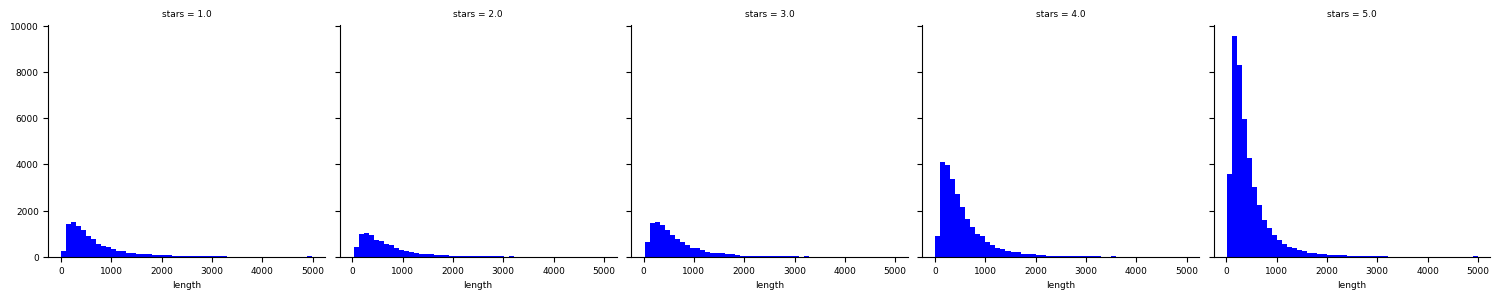

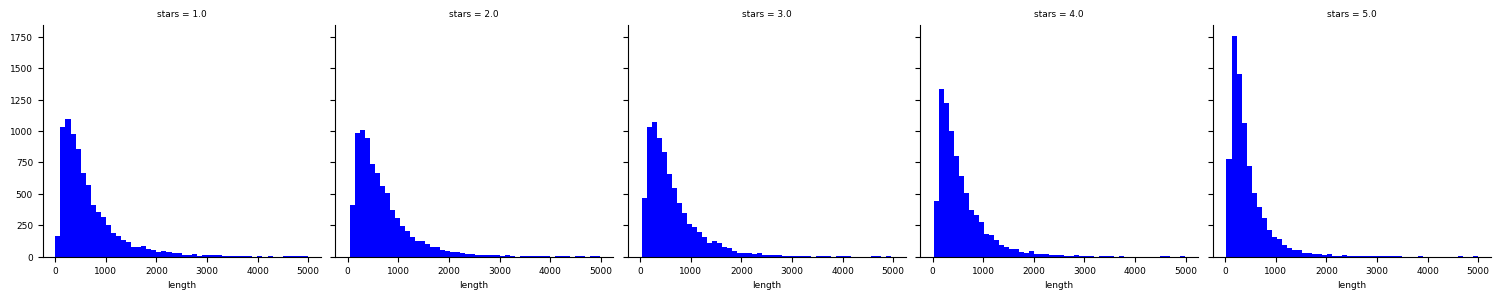

In [85]:
graph = sns.FacetGrid(data=yelp_sample_unequal, col='stars')
graph.map(plt.hist, 'length', bins=50, color='blue')

graph = sns.FacetGrid(data=yelp_sample_equal, col='stars')
graph.map(plt.hist, 'length', bins=50, color='blue')

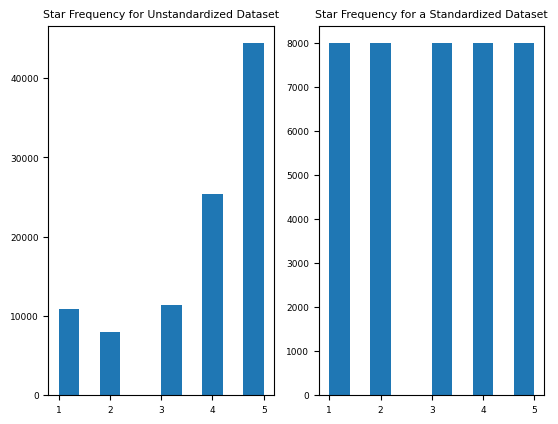

In [82]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.hist(yelp_sample_unequal['stars'])
plt.title('Star Frequency for Unstandardized Dataset')

plt.subplot(1, 2, 2) # index 2
plt.hist(yelp_sample_equal['stars'])
plt.title('Star Frequency for a Standardized Dataset')

plt.show()

#### We want to note here that our sample dataset is biased to more positive reviews than negative reviews. Additionally, positive reviews are typically longer than negative reviews. It will be important to keep these insights in mind when we train. As a result, we should proceed with caution when classifying, training, and predicting with this dataset. Additionally, this could impact applying Tweet data on a trained learning model.

### 5. Create functions to test and plot 18 variations of 3 hyperparameters (star class, n-grams, and standardized star count) on  learning models.

#### Create lists of all hyperparameter combinations 

In [43]:
combo = list(product(('all_stars', '1_5_stars', '1_3_5_stars'), 
                     ('unigram', 'bigram', 'trigram'), 
                     ('equal','unequal')))

new_combo = list(product(('1_5_stars', '1_3_5_stars'), 
                         ('unigram', 'bigram', 'trigram'), 
                         ('equal','unequal')))
new_combo = (new_combo + [('all_stars','unigram', 'equal')] 
                       + [('all_stars','bigram', 'equal')] 
                       + [('all_stars','unigram', 'unequal')])

brand_new_combo = list(product(('1_5_stars', '1_3_5_stars', 'all_stars'),
                               ('unigram', 'bigram'), 
                               ('equal', 'unequal')))
brand_new_combo = (brand_new_combo + [('1_5_stars', 'trigram', 'equal')] 
                                   + [('1_3_5_stars', 'trigram', 'equal')])

final_combo = [('1_5_stars', 'unigram', 'equal'), ('1_5_stars', 'unigram', 'unequal'), 
               ('1_3_5_stars', 'unigram', 'equal'), ('1_3_5_stars', 'unigram', 'unequal'), 
               ('all_stars', 'unigram', 'equal'), ('all_stars', 'unigram', 'unequal')]

Naive Bayes: 
- all

Logistic Regression:
- Exclude (all_stars, trigram, equal) and (all_stars, trigram, unequal)

Decision Trees:
- Exclude (all_stars, trigram, equal), (all_stars, trigram, unequal), (1_5_stars, trigram, unequal), (1_3_5_stars, trigram, unequal)

Random Forest:
- Exclude (all_stars, trigram, equal), (all_stars, trigram, unequal), (all_stars, bigram, equal), (all_stars, bigram, unequal), (1_5_stars, bigram, unequal), (1_5_stars, bigram, equal), (1_5_stars, trigram, equal), (1_5_stars, trigram, unequal), (1_3_5_stars, trigram, equal), (1_3_5_stars, trigram, unequal), (1_3_5_stars, bigram, unequal), (1_3_5_stars, bigram, equal)


#### It's worth noting here that we ran into **significantly long runtimes** with certain combinations, which is why you see certain models test fewer combinations. This mainly applies to trigram and sometimes bigram datasets, as the number of unique word combinations (which each end up being a feature) dramatically increases with larger n-grams. This is also sometimes true with the all_stars hyperparameter variation, as the number of reviews increase dramatically. This is further elaborated on when discussing the Big O notation and overall runtime limitations.

In [9]:
def star_df(star, df):
    """
    This function takes in a string of star classification and subsets the 
    rows of the data for the corressponding stars
    """
    
    if 'all_stars' == star:
        return  df
    elif '1_5_stars' == star:
        return df[(df['stars']==1) | (df['stars']==5)]
    else:
        return df[(df['stars']==1) | (df['stars']==3) | (df['stars']==5)]

In [127]:
def n_gram_df(str, df):
    """
    This function takes in a string for the corresponding n-gram and the 
    subsetted star data frame. Then creates the ngram and then creates a 
    Spacy Sparce data matrix.
    """
    
    x_df = df['text']
    if str == 'unigram':
        unigram_vocab = (CountVectorizer(ngram_range=(1,1), stop_words='english')
                         .fit(df.loc[:, 'text']))
        return unigram_vocab.transform(x_df)
        
    elif str == 'bigram':
        bigram_vocab = (CountVectorizer(ngram_range = (2, 2), stop_words='english')
                        .fit(df.loc[:, 'text']))
        return bigram_vocab.transform(x_df)
    else: 
        trigram_vocab = (CountVectorizer(ngram_range = (3, 3), stop_words='english')
                         .fit(df.loc[:, 'text']))
        return trigram_vocab.transform(x_df)

In [20]:
def model_to_acuracy(model,x_train, x_test, y_train, y_test, combo):
    """
    This function takes in the train and test data each variation, 
    visualizes, calculates model prediction, and returns accuracy score as a numpy int.
    """

    model.fit(x_train, y_train)
    predmnb = model.predict(x_test)
    y = pd.concat([y_train, y_test])

    #accuracy score only for even data
    if y.value_counts().nunique() == 1:

        score = round(accuracy_score(y_test, predmnb) * 100, 2)
        print(combo, "Accuracy Score:", score)
        print()

    #f1 for uneven data 
    else:
        score = round(f1_score(y_test, predmnb, average='weighted') * 100, 2)
        print(combo, "f1_score:", score)
        print()

    return score

In [21]:
def hyper_tuning(yelp_sample_equal, yelp_sample_unequal, model, hyper_combo):
    """
    This function calculates the accuracy score for each variation of 
    hyperpermeters for a given model
    """

    score_lst = []
    time_lst = []
    
    for tup in hyper_combo:
        
        star, gram, equal = tup

        if equal == 'equal':

            yelp_classify_equal = yelp_sample_equal.loc[:, ['stars', 'text']]
            star_class_df = star_df(star, yelp_classify_equal)
            x_df = n_gram_df(gram, star_class_df)
        else: 
            yelp_classify_unequal = yelp_sample_unequal.loc[:, ['stars', 'text']]
            star_class_df = star_df(star, yelp_classify_unequal)
            x_df = n_gram_df(gram, star_class_df)

        y_df = star_class_df['stars']

        (x_train, x_test, y_train, y_test) = train_test_split(x_df, 
                                                 y_df, 
                                                 test_size=0.2, 
                                                 random_state=101)
        start_time = time.time()
        score = model_to_acuracy(model,x_train, x_test, y_train, y_test, tup)
        end_time = time.time()
        score_lst.append(score)
        time_lst.append((float(end_time) - float(start_time))/float(60))

    return score_lst, time_lst

In [106]:
def scatter_graph(combo, score, time_list, model_name):
    """
    This function plots accuracy for each varation for a given model 
    """

    x1 = []
    x2 = []
    x3 = []

    y1 = []
    y2 = []
    y3 = []

    for i, v in enumerate(combo):   
        if v[1] == "unigram":
            y1.append(score[i])
            x1.append(time_list[i])
        if v[1] == "bigram":
            y2.append(score[i])
            x2.append(time_list[i])
        if v[1] == "trigram":
            y3.append(score[i])
            x3.append(time_list[i])
    
    fig, ax = plt.subplots()
    
    #resizing window 
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('test2png.png', dpi=100)

    # depict illustration
    ax.scatter(x1, y1)
    ax.scatter(x2, y2)
    ax.scatter(x3, y3)
 
    # apply legend()
    ax.legend(["unigram" , "bigram", "trigram"])

    #labels 
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Run Time')
    ax.set_title(model_name + ' Accuracy Plot by Run Time')
    
    plt.show()

In [121]:

def graph_score(combo, score, model_name):
    """
    This function plots accuracy and f1 scores for each varation for a given model 

    """
    #changing data type 
    x = [str(label) for label in combo]
    y = [float(value) for value in score]

    fig, ax = plt.subplots()

    #resizing window 
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('test2png.png', dpi=100)

    ax.bar(x, y)

    ax.set_xticks(range(len(combo)))
    ax.set_xticklabels(x, rotation=-45, ha="left")

    #labels 
    ax.set_ylabel('Accuracy and F1 Score')
    ax.set_title(model_name + ' Accuracy Plot for Hyperparameter Tuning')

    plt.show()



In [120]:
def graph_time(combo, time_lst, model_name):
    """
    This function plots accuracy for each varation for a given model 

    """
    #changing data type 
    x = [str(label) for label in combo]
    y = [float(value) for value in time_lst]

    fig, ax = plt.subplots()

    #resizing window 
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('test2png.png', dpi=100)

    ax.bar(x, y)

    ax.set_xticks(range(len(combo)))
    ax.set_xticklabels(x, rotation=-45, ha="left")

    #labels 
    ax.set_ylabel('Runtime')
    ax.set_title(model_name + ' Model Run Time For Hyperparameter Tuning')

    plt.show()

### 6. Modeling reviews with Multinomial Naive Bayes (since we're working with sparse data, we can't rely on Gaussian Naive Bayes assumptions).

In [128]:
score, time_lst_nb = hyper_tuning(yelp_sample_equal, 
                                  yelp_sample_unequal, 
                                  MultinomialNB(), 
                                  combo)

('all_stars', 'unigram', 'equal') Accuracy Score: 51.38

('all_stars', 'unigram', 'unequal') f1_score: 58.44

('all_stars', 'bigram', 'equal') Accuracy Score: 49.74

('all_stars', 'bigram', 'unequal') f1_score: 54.61

('all_stars', 'trigram', 'equal') Accuracy Score: 29.68

('all_stars', 'trigram', 'unequal') f1_score: 35.59

('1_5_stars', 'unigram', 'equal') Accuracy Score: 94.46

('1_5_stars', 'unigram', 'unequal') f1_score: 94.57

('1_5_stars', 'bigram', 'equal') Accuracy Score: 90.08

('1_5_stars', 'bigram', 'unequal') f1_score: 91.53

('1_5_stars', 'trigram', 'equal') Accuracy Score: 56.57

('1_5_stars', 'trigram', 'unequal') f1_score: 42.69

('1_3_5_stars', 'unigram', 'equal') Accuracy Score: 77.91

('1_3_5_stars', 'unigram', 'unequal') f1_score: 84.24

('1_3_5_stars', 'bigram', 'equal') Accuracy Score: 76.01

('1_3_5_stars', 'bigram', 'unequal') f1_score: 81.84

('1_3_5_stars', 'trigram', 'equal') Accuracy Score: 42.48

('1_3_5_stars', 'trigram', 'unequal') f1_score: 41.81



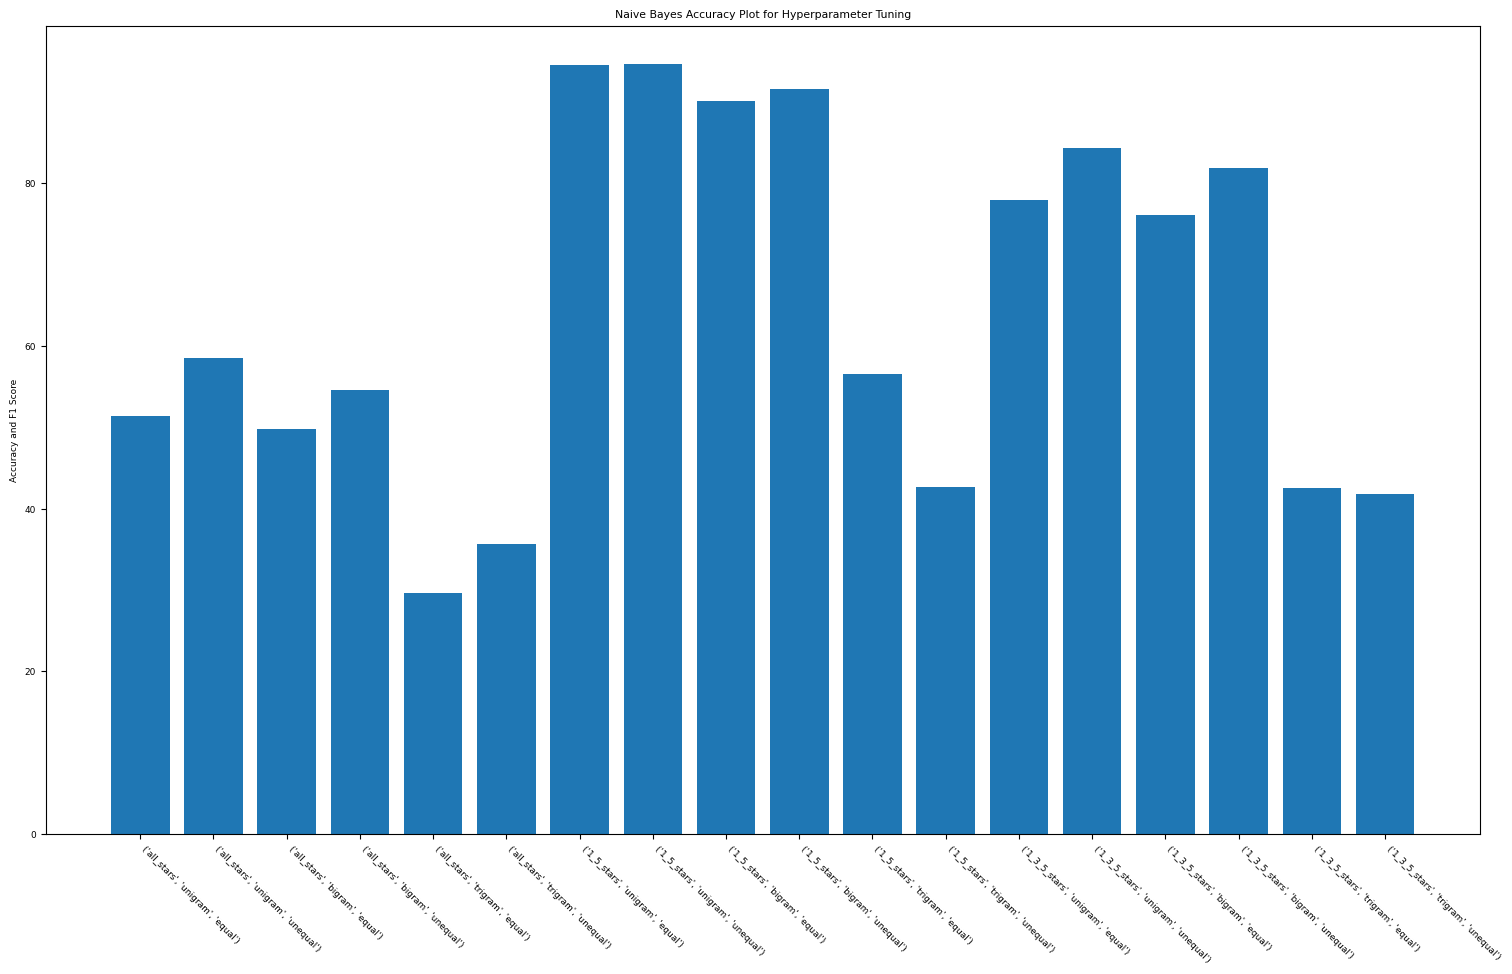

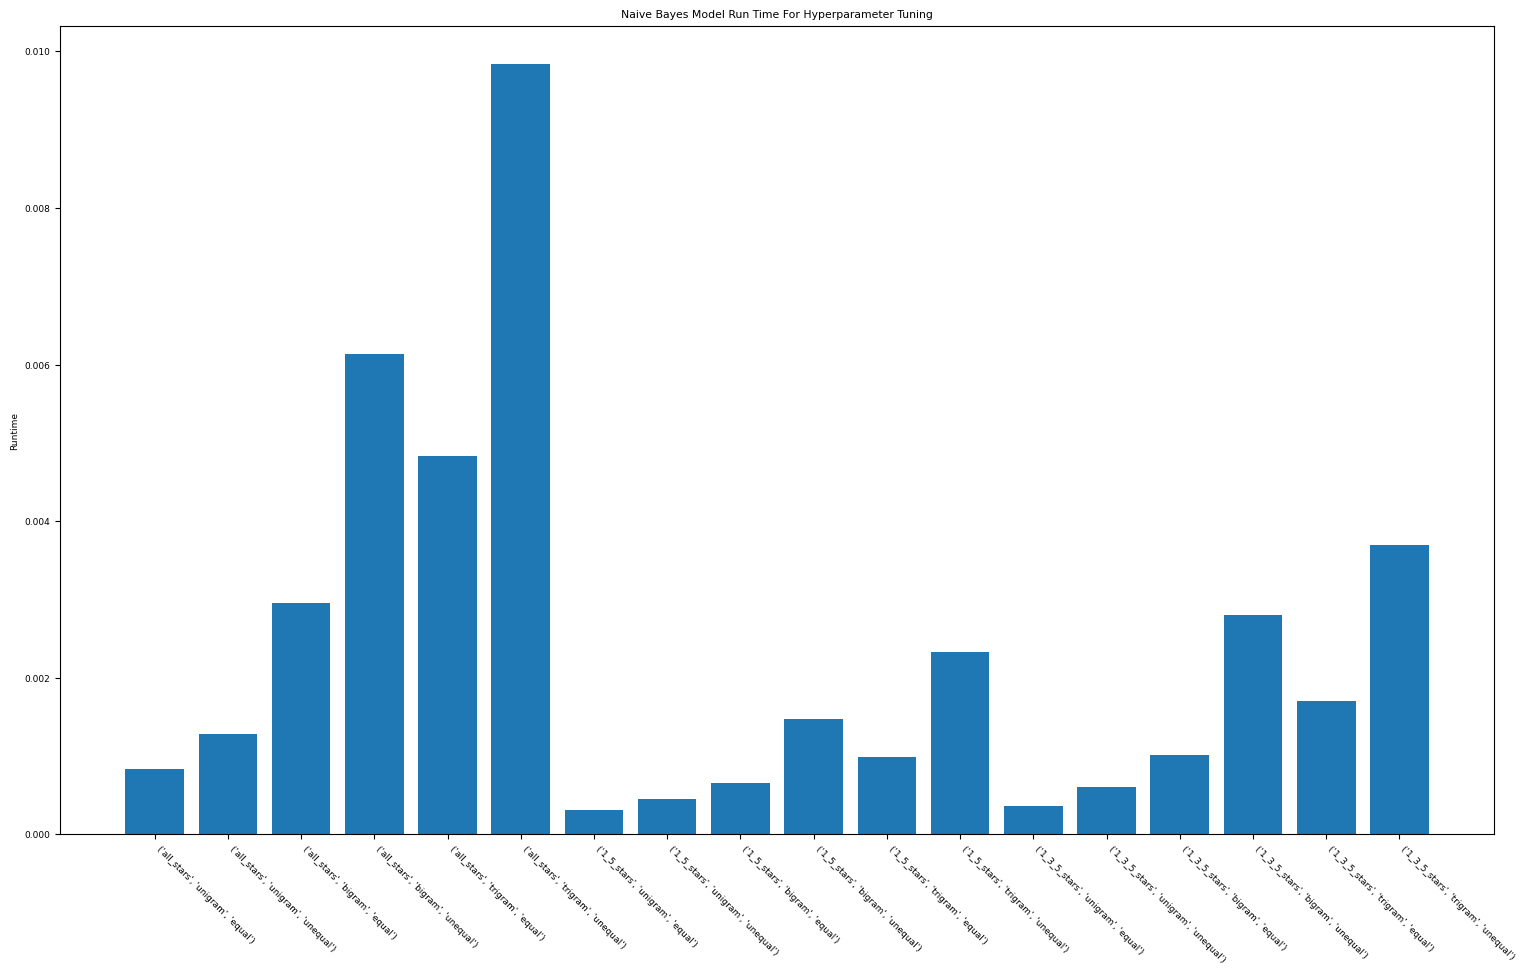

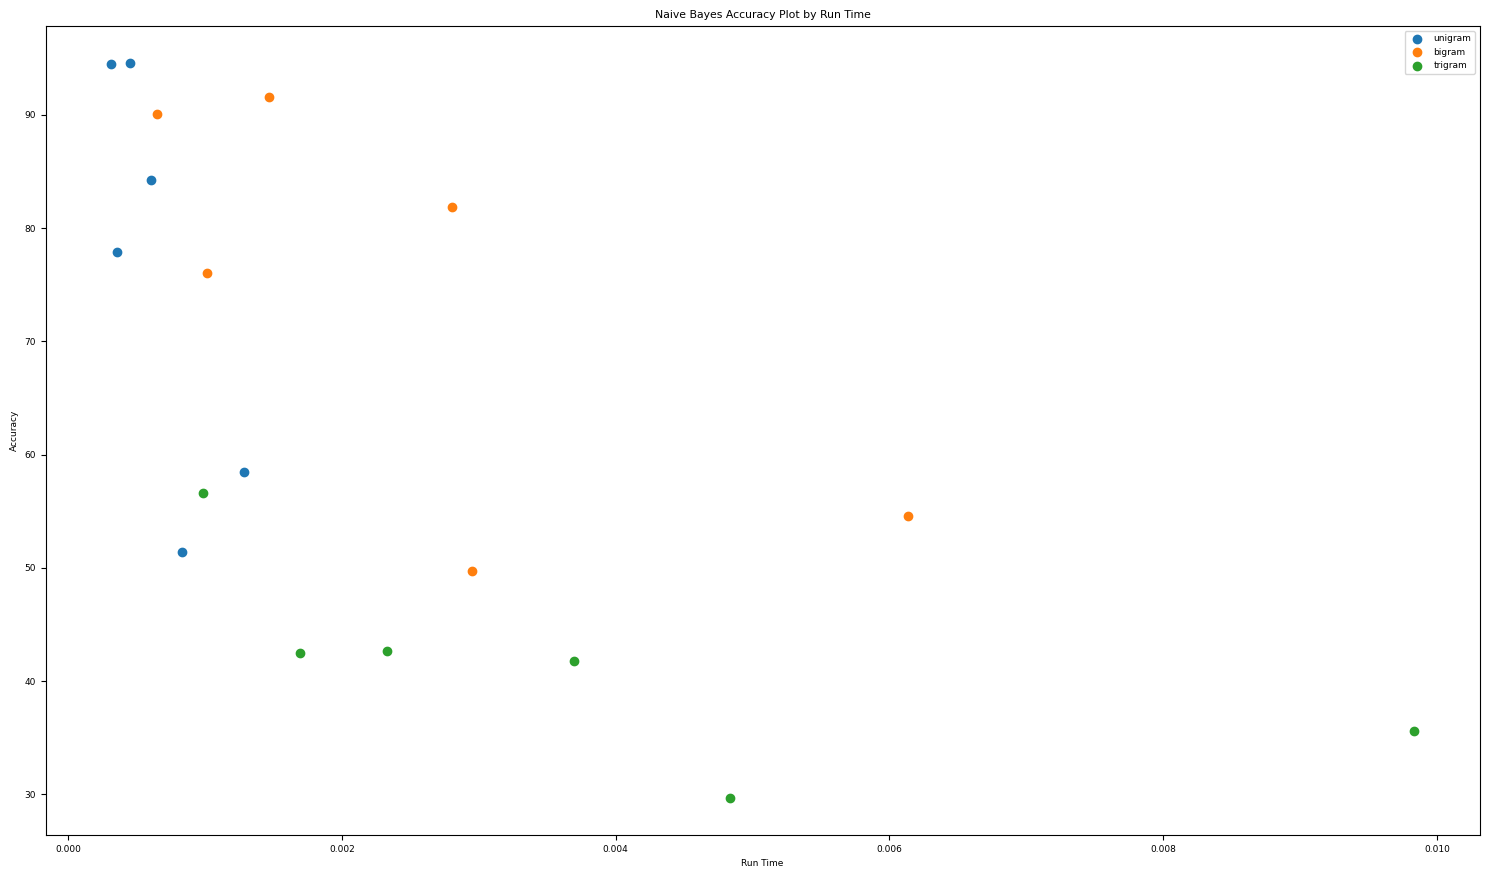

In [129]:
graph_score(combo, score, "Naive Bayes")
graph_time(combo, time_lst_nb, "Naive Bayes")
scatter_graph(combo, score, time_lst_nb, "Naive Bayes")

### 7. Modeling reviews with the Decision Tree Classifier.

In [24]:
dt_score, time_lst_dt = hyper_tuning(yelp_sample_equal,
                                     yelp_sample_unequal, 
                                     DecisionTreeClassifier(), 
                                     brand_new_combo)

('1_5_stars', 'unigram', 'equal') Accuracy Score: 85.11

('1_5_stars', 'unigram', 'unequal') f1_score: 91.18

('1_5_stars', 'bigram', 'equal') Accuracy Score: 80.26

('1_5_stars', 'bigram', 'unequal') f1_score: 84.77

('1_3_5_stars', 'unigram', 'equal') Accuracy Score: 65.83

('1_3_5_stars', 'unigram', 'unequal') f1_score: 75.18

('1_3_5_stars', 'bigram', 'equal') Accuracy Score: 62.15

('1_3_5_stars', 'bigram', 'unequal') f1_score: 71.0

('all_stars', 'unigram', 'equal') Accuracy Score: 40.92

('all_stars', 'unigram', 'unequal') f1_score: 48.74

('all_stars', 'bigram', 'equal') Accuracy Score: 37.16

('all_stars', 'bigram', 'unequal') f1_score: 46.38

('1_5_stars', 'trigram', 'equal') Accuracy Score: 62.89

('1_3_5_stars', 'trigram', 'equal') Accuracy Score: 46.61



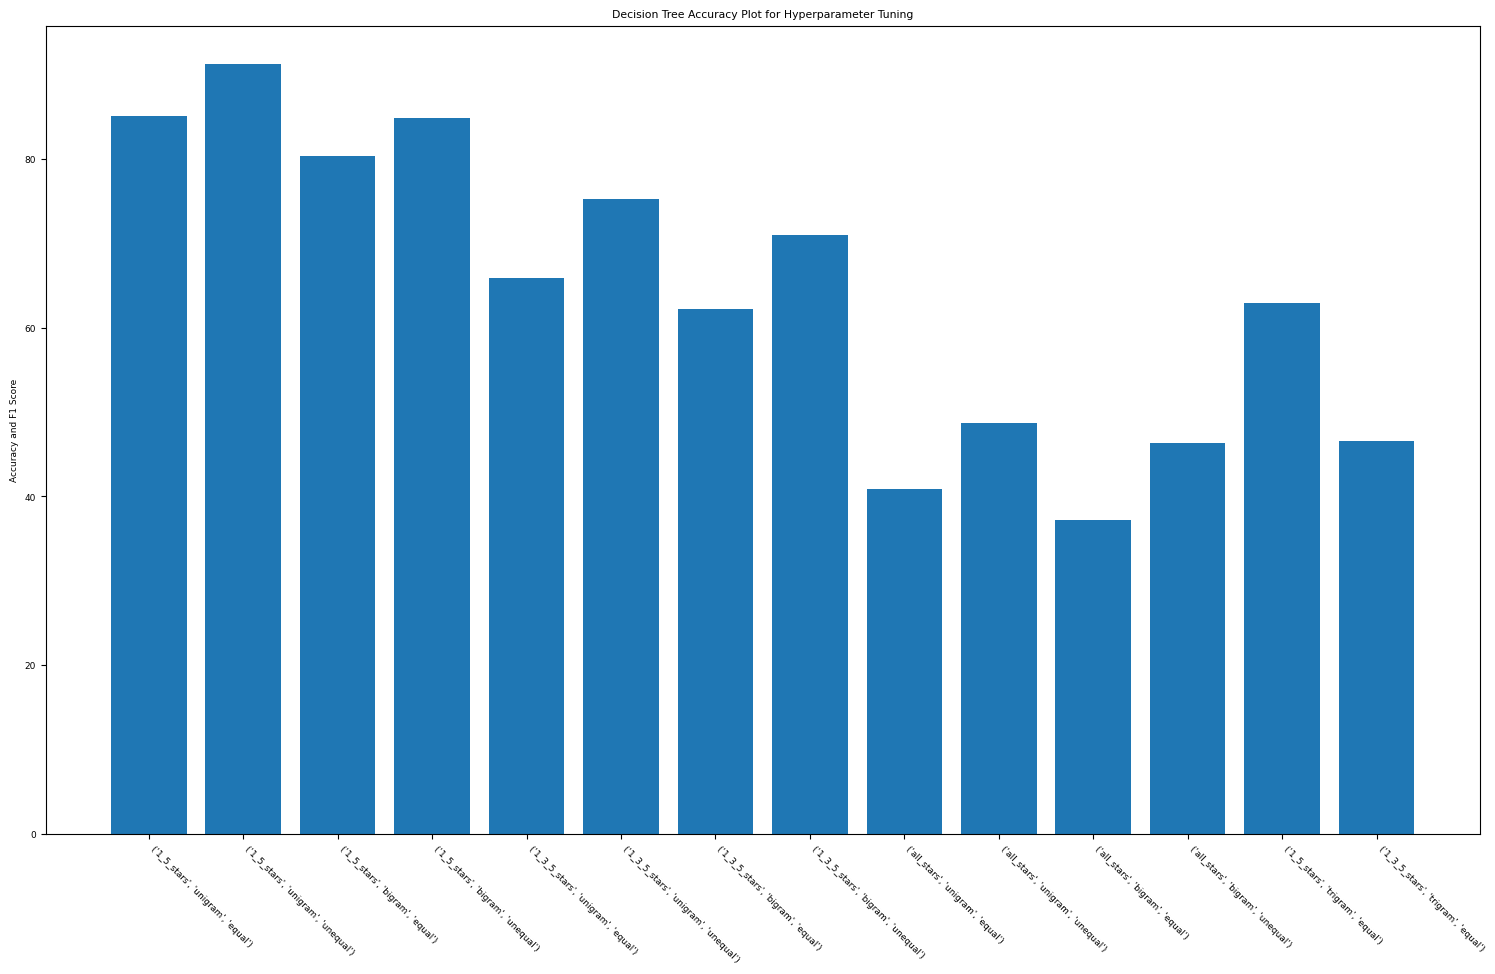

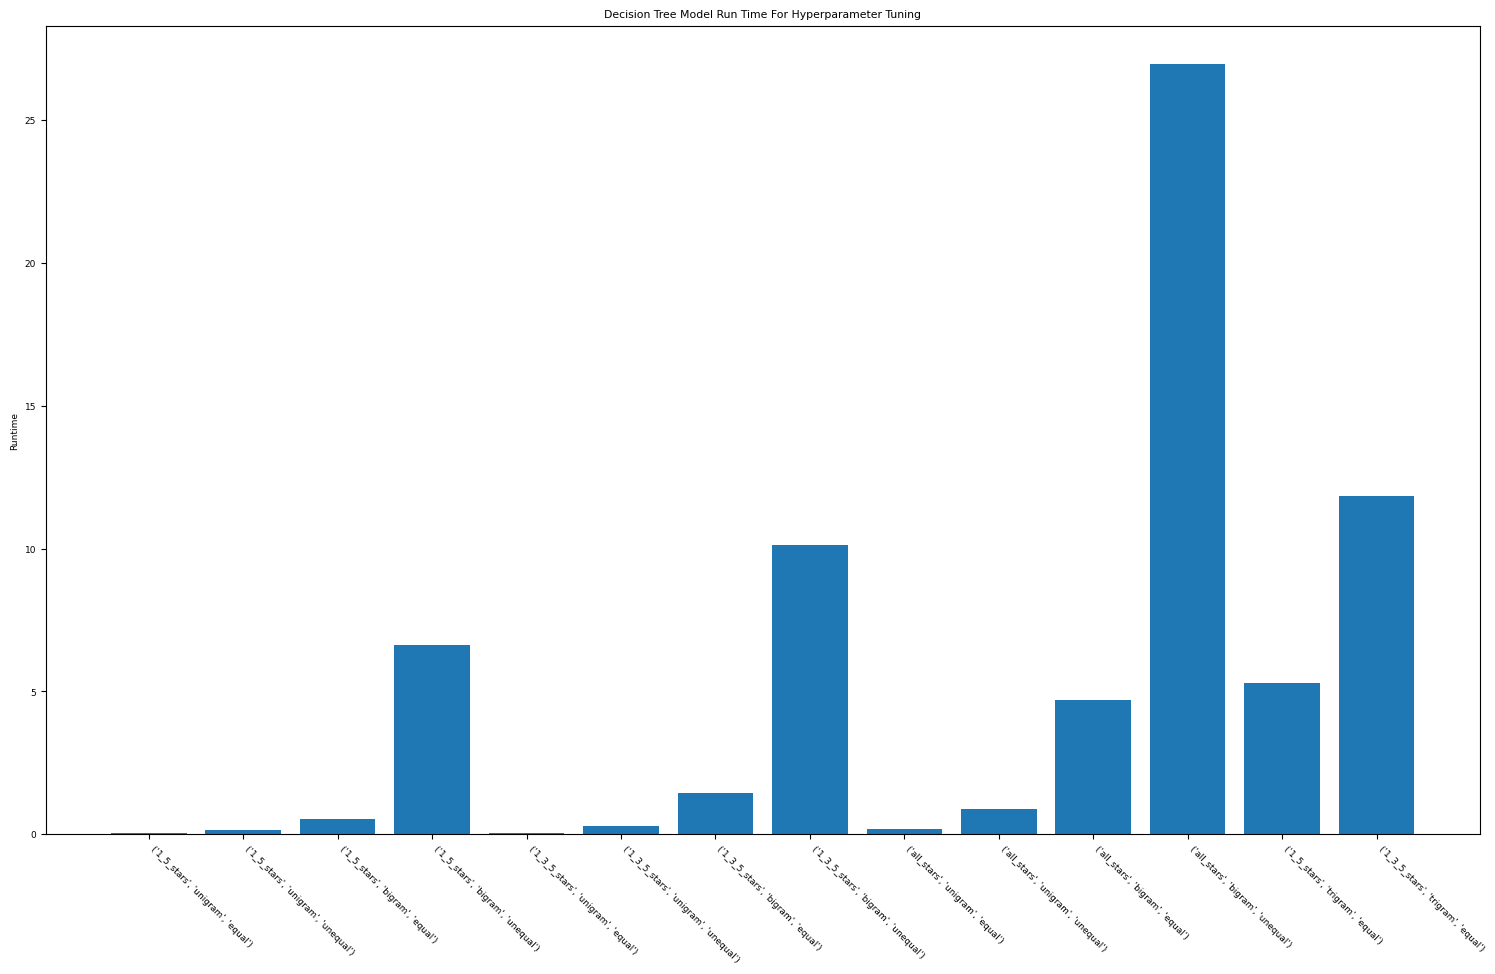

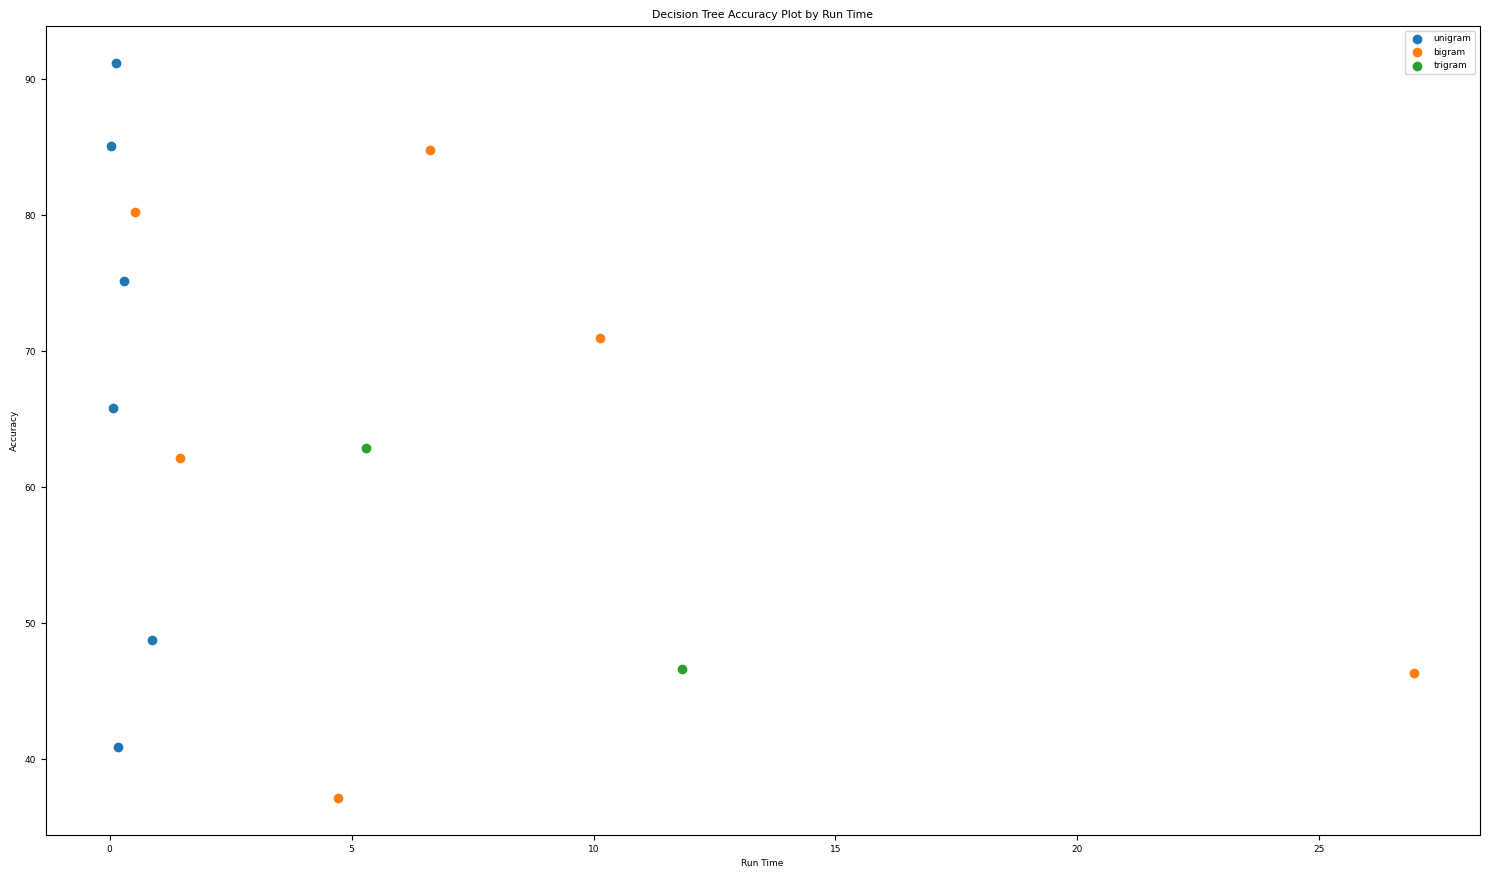

In [123]:
graph_score(brand_new_combo, dt_score, "Decision Tree")
graph_time(brand_new_combo, time_lst_dt, "Decision Tree")
scatter_graph(brand_new_combo, dt_score, time_lst_dt, "Decision Tree")

### 8. Modeling reviews with Random Forest Classifier.

In [44]:
rf_score, time_lst_rf  = hyper_tuning(yelp_sample_equal, 
                                      yelp_sample_unequal, 
                                      RandomForestClassifier(), 
                                      final_combo)

('1_5_stars', 'unigram', 'equal') Accuracy Score: 94.43

('1_5_stars', 'unigram', 'unequal') f1_score: 94.11

('1_3_5_stars', 'unigram', 'equal') Accuracy Score: 78.51

('1_3_5_stars', 'unigram', 'unequal') f1_score: 77.09

('all_stars', 'unigram', 'equal') Accuracy Score: 49.8

('all_stars', 'unigram', 'unequal') f1_score: 49.0



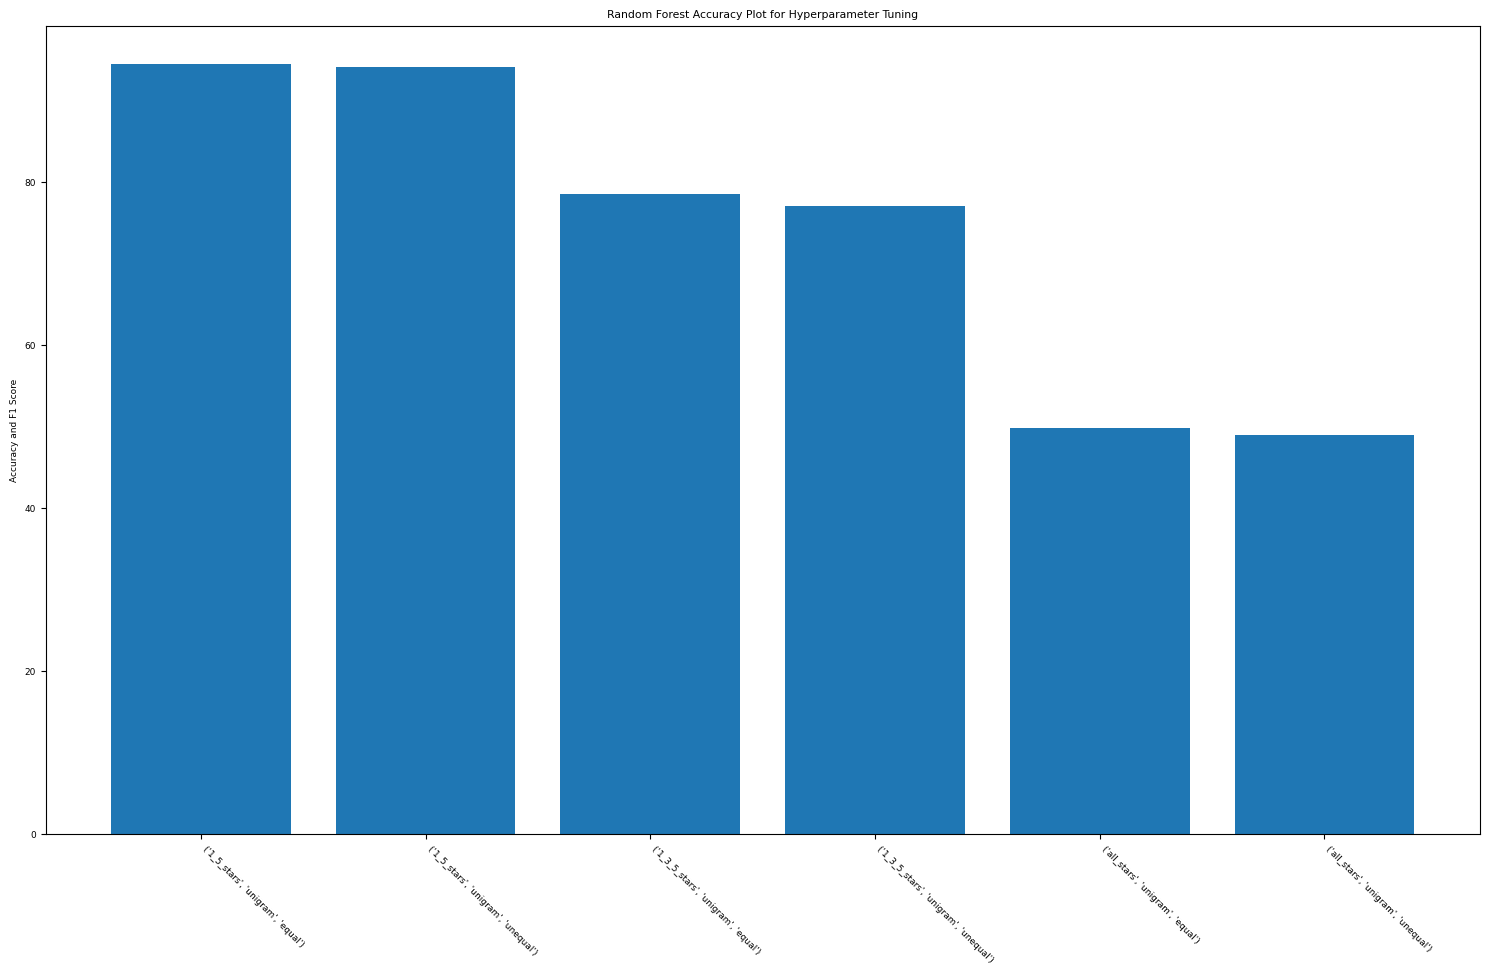

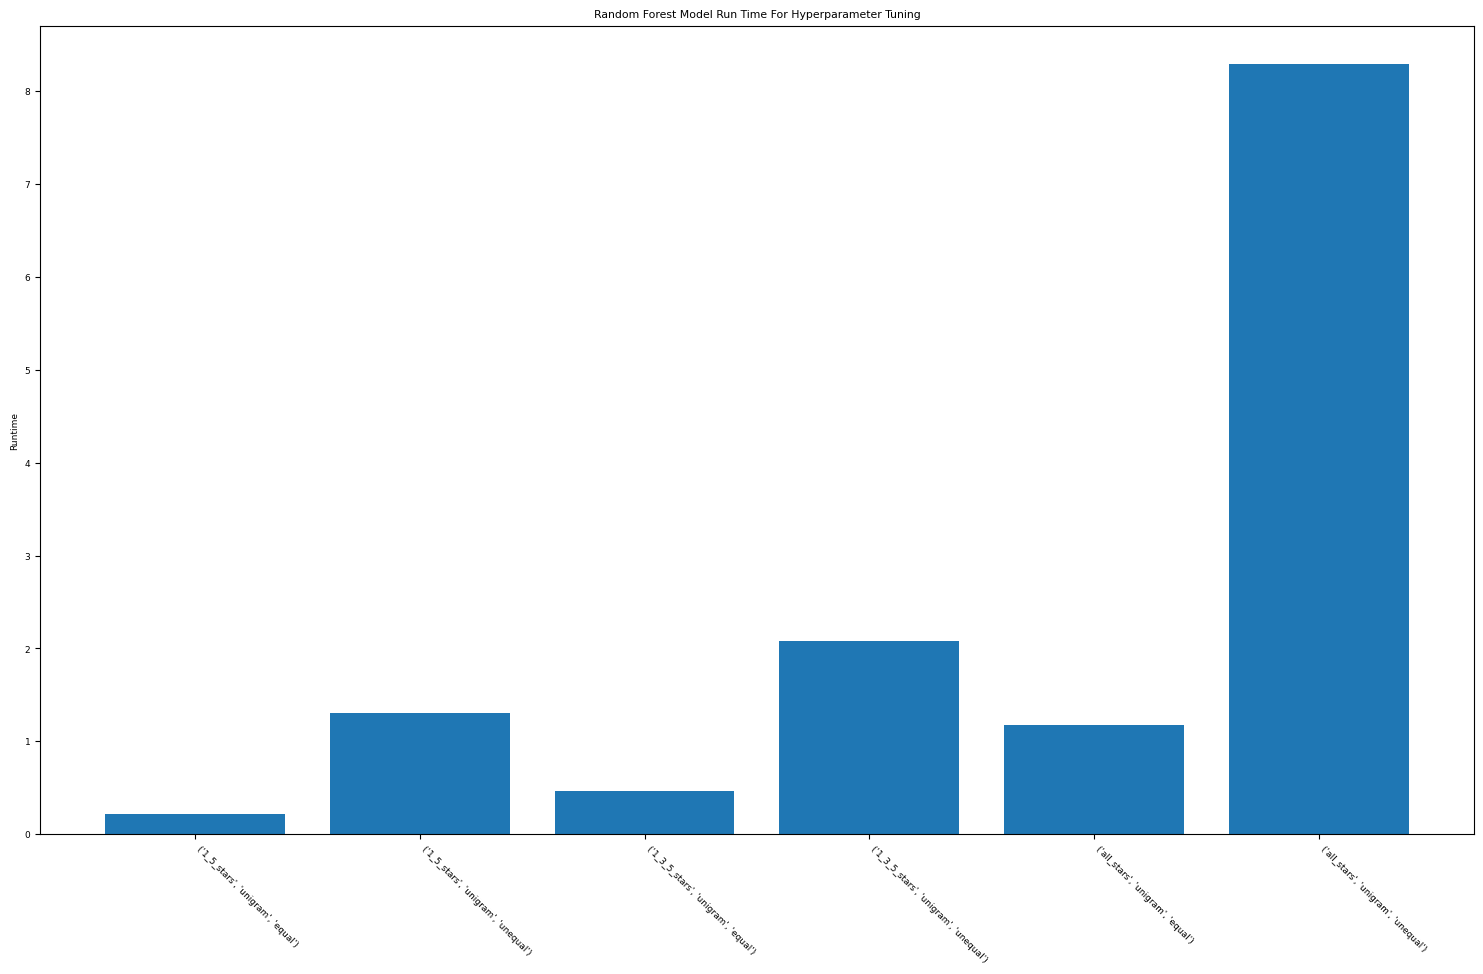

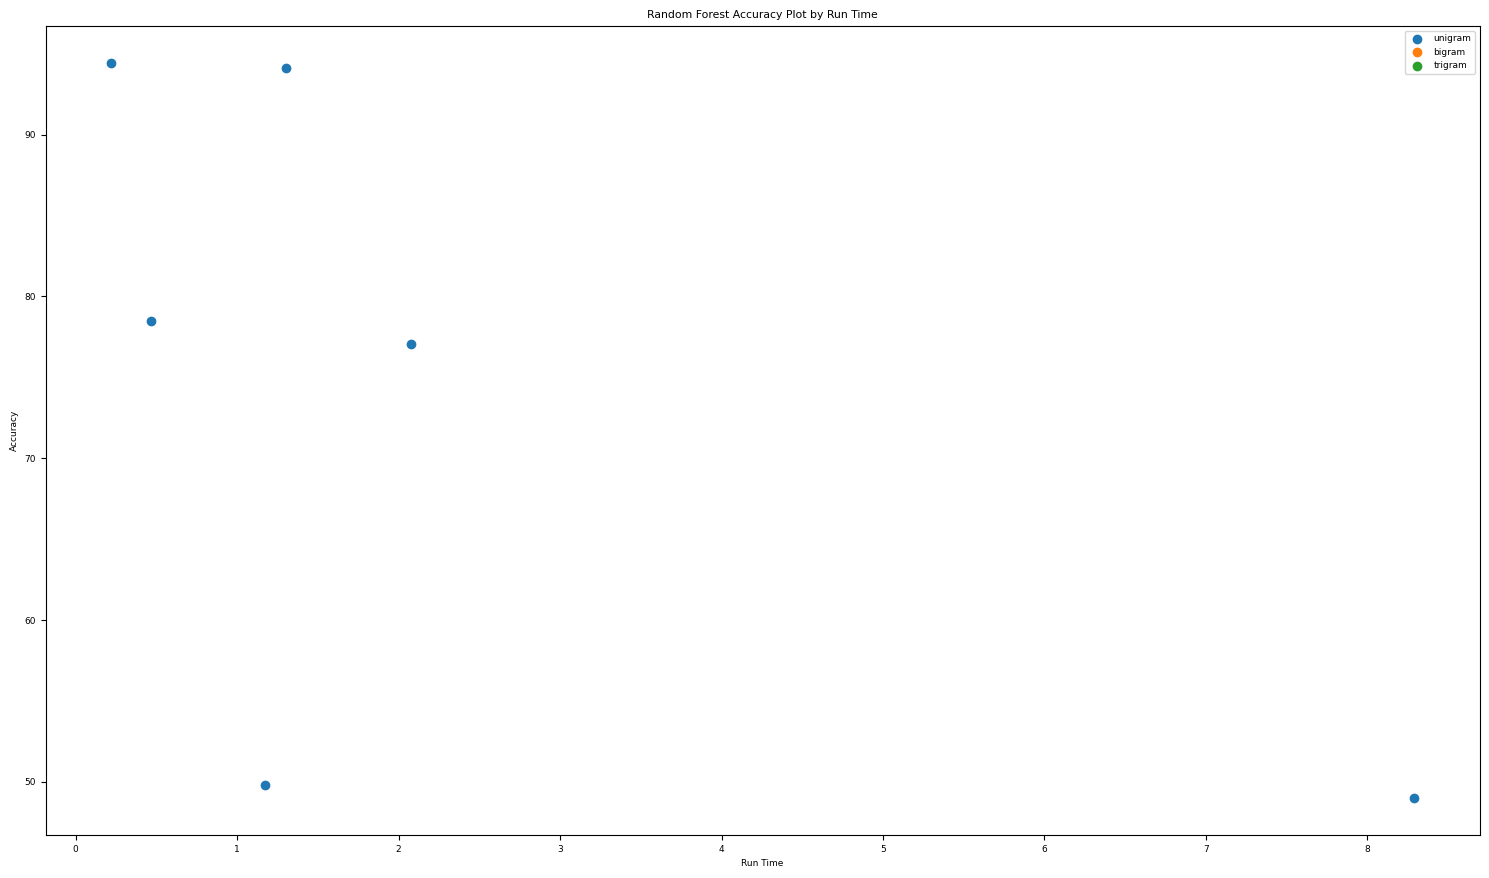

In [124]:
graph_score(final_combo, rf_score, "Random Forest")
graph_time(final_combo, time_lst_rf, "Random Forest")
scatter_graph(final_combo, rf_score, time_lst_rf, "Random Forest")

### 9. Modeling reviews with Logistic Regression (note that the maximum number of iterations is also tested).

In [31]:
var_holder = {}
max_iter_list = [100,1000,10000] 

for iter in max_iter_list:
    print("Number of Iterations: ", iter)
    (var_holder['lr_acc_' + str(iter)], 
     var_holder['time_lst_' + str(iter)]) = hyper_tuning(yelp_sample_equal, 
                                                         yelp_sample_unequal, 
                                                         LogisticRegression(max_iter=iter), 
                                                         new_combo)

Number of Iterations:  100
('1_5_stars', 'unigram', 'equal') Accuracy Score: 95.28

('1_5_stars', 'unigram', 'unequal') f1_score: 97.0

('1_5_stars', 'bigram', 'equal') Accuracy Score: 90.24

('1_5_stars', 'bigram', 'unequal') f1_score: 90.99

('1_5_stars', 'trigram', 'equal') Accuracy Score: 63.17

('1_5_stars', 'trigram', 'unequal') f1_score: 74.3

('1_3_5_stars', 'unigram', 'equal') Accuracy Score: 80.03

('1_3_5_stars', 'unigram', 'unequal') f1_score: 86.47

('1_3_5_stars', 'bigram', 'equal') Accuracy Score: 74.19

('1_3_5_stars', 'bigram', 'unequal') f1_score: 79.88

('1_3_5_stars', 'trigram', 'equal') Accuracy Score: 46.65

('1_3_5_stars', 'trigram', 'unequal') f1_score: 57.22

('all_stars', 'unigram', 'equal') Accuracy Score: 51.11

('all_stars', 'bigram', 'equal') Accuracy Score: 48.8

('all_stars', 'unigram', 'unequal') f1_score: 59.54

Number of Iterations:  1000
('1_5_stars', 'unigram', 'equal') Accuracy Score: 95.28

('1_5_stars', 'unigram', 'unequal') f1_score: 97.0

('1_5

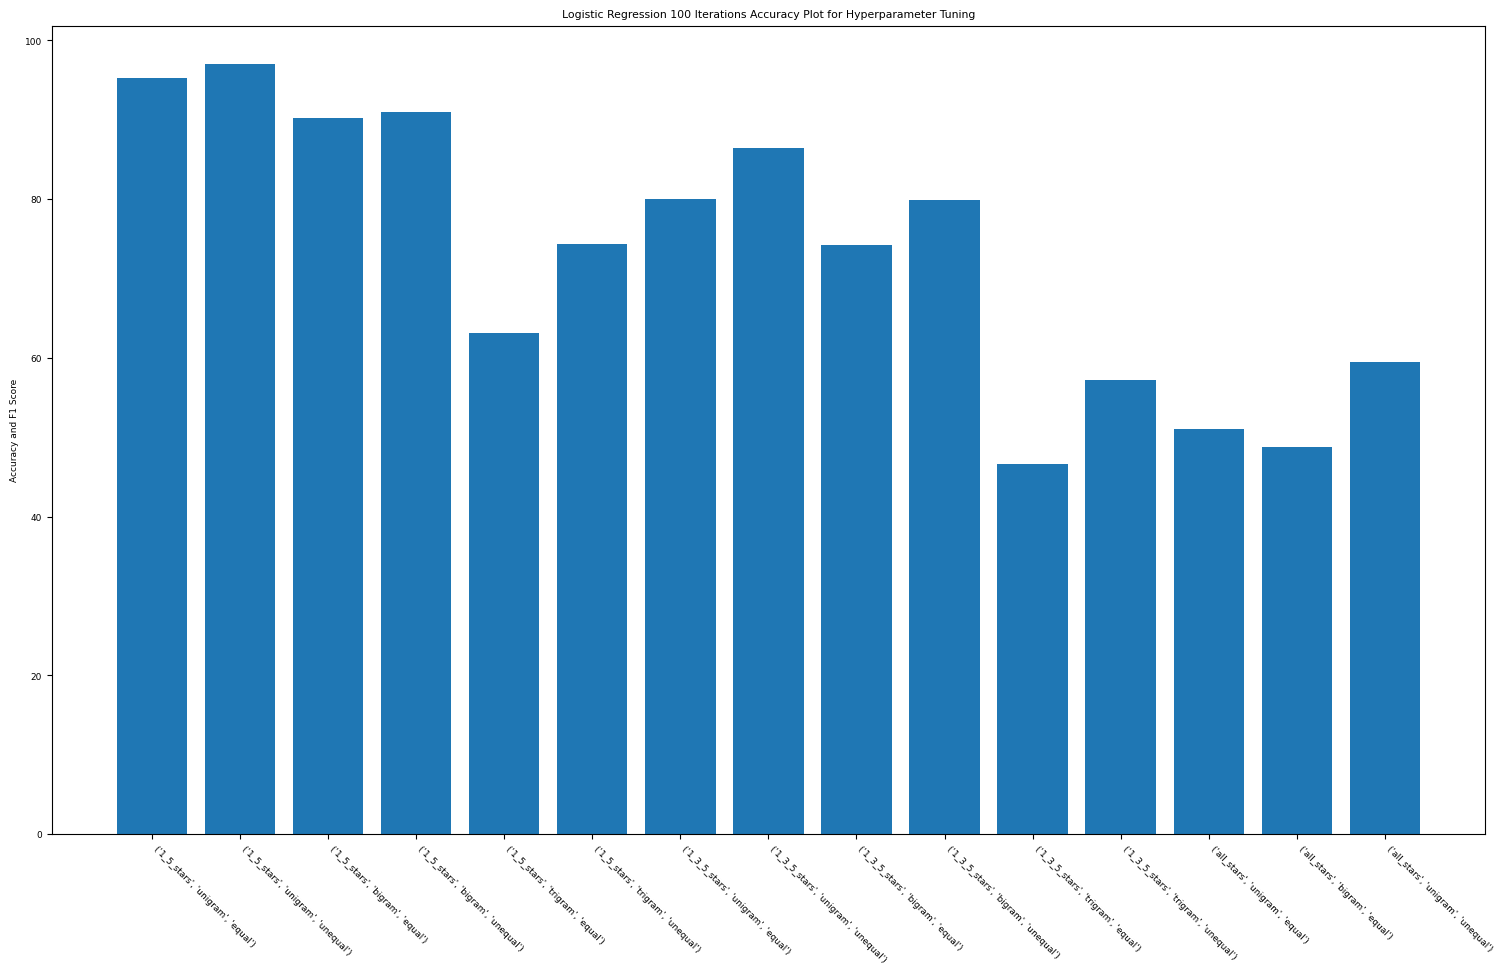

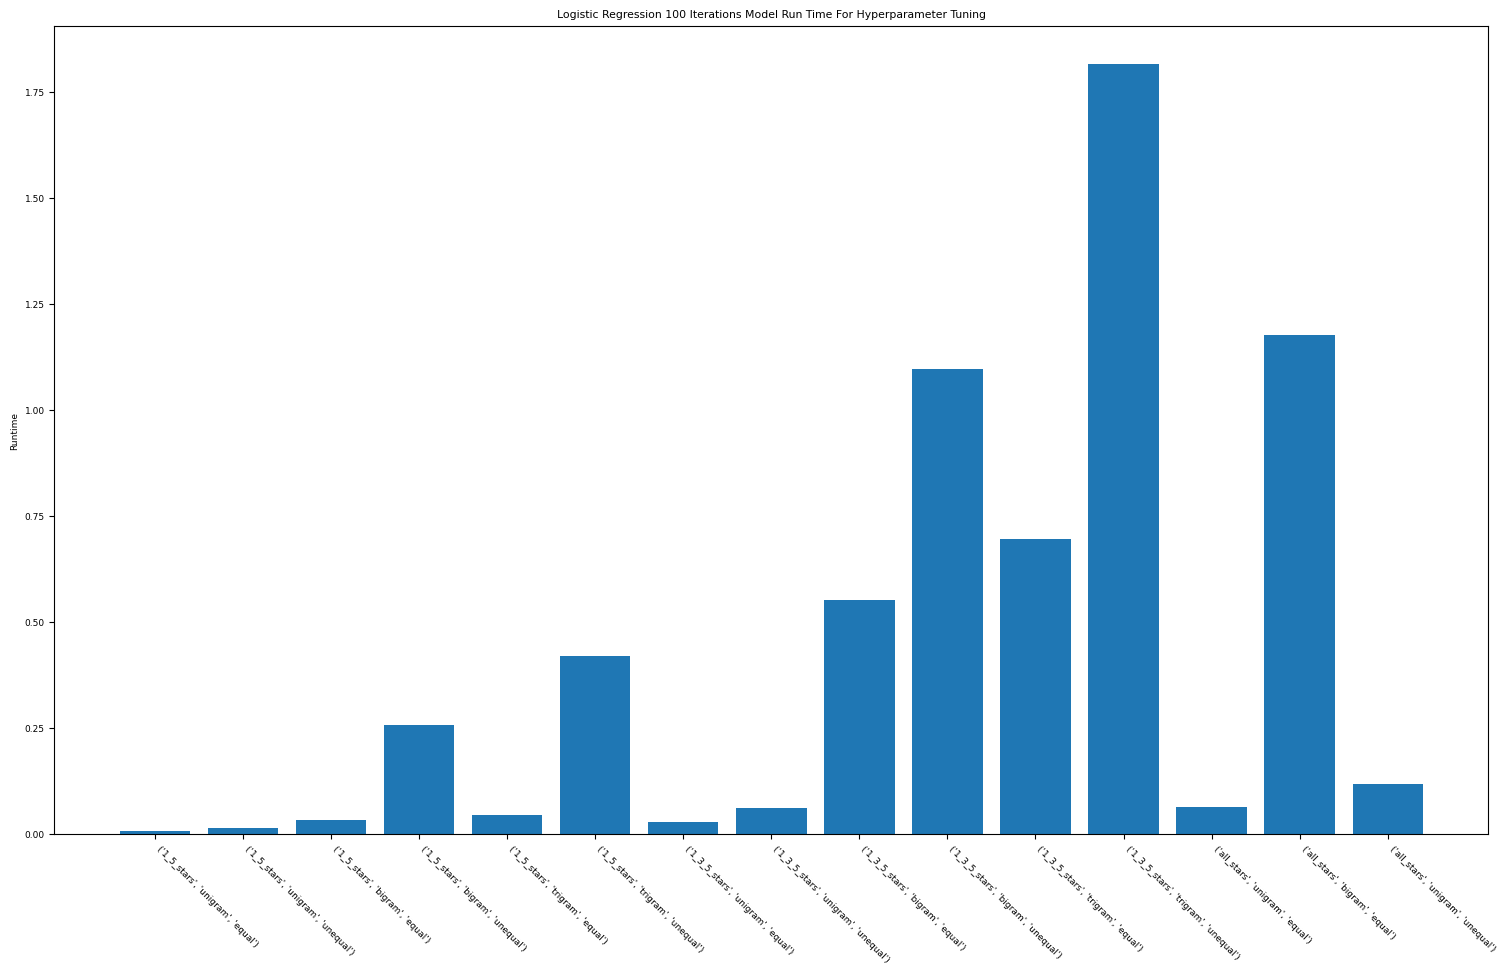

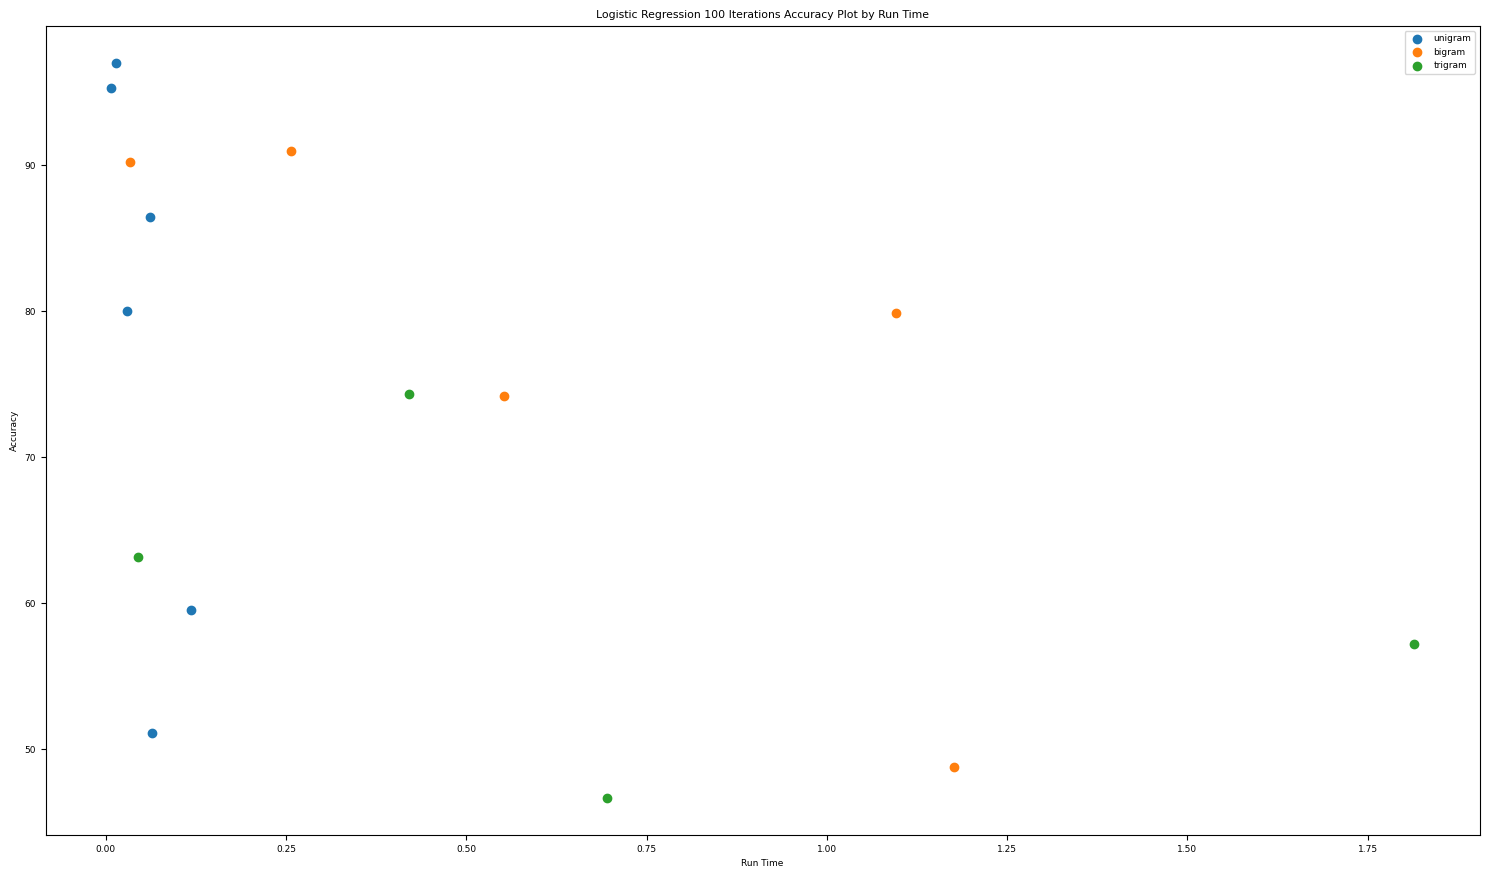

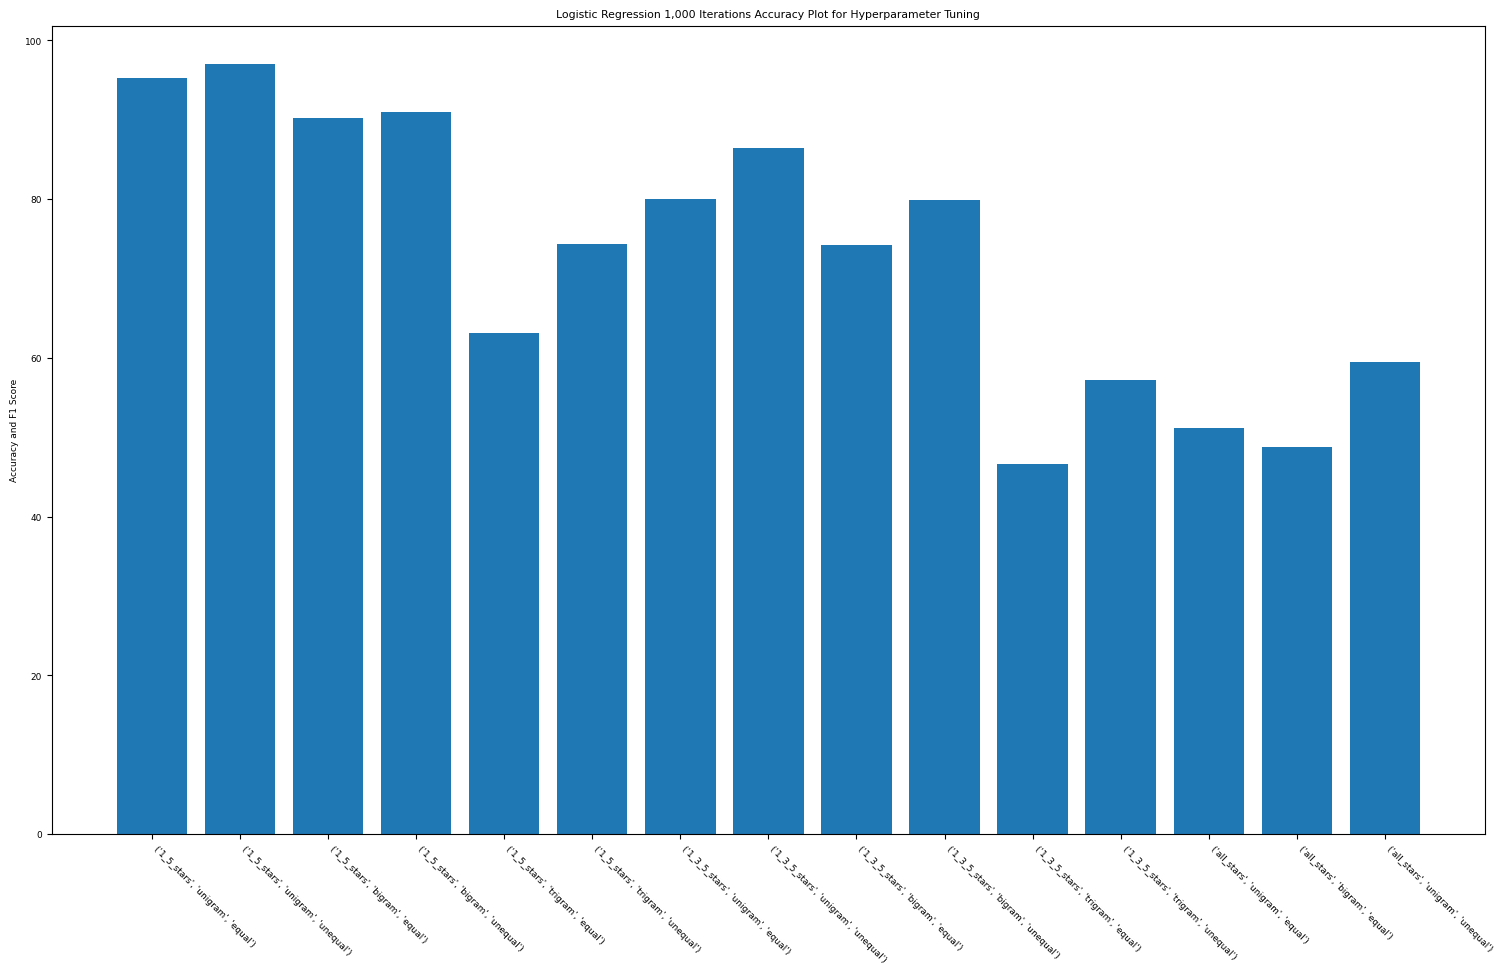

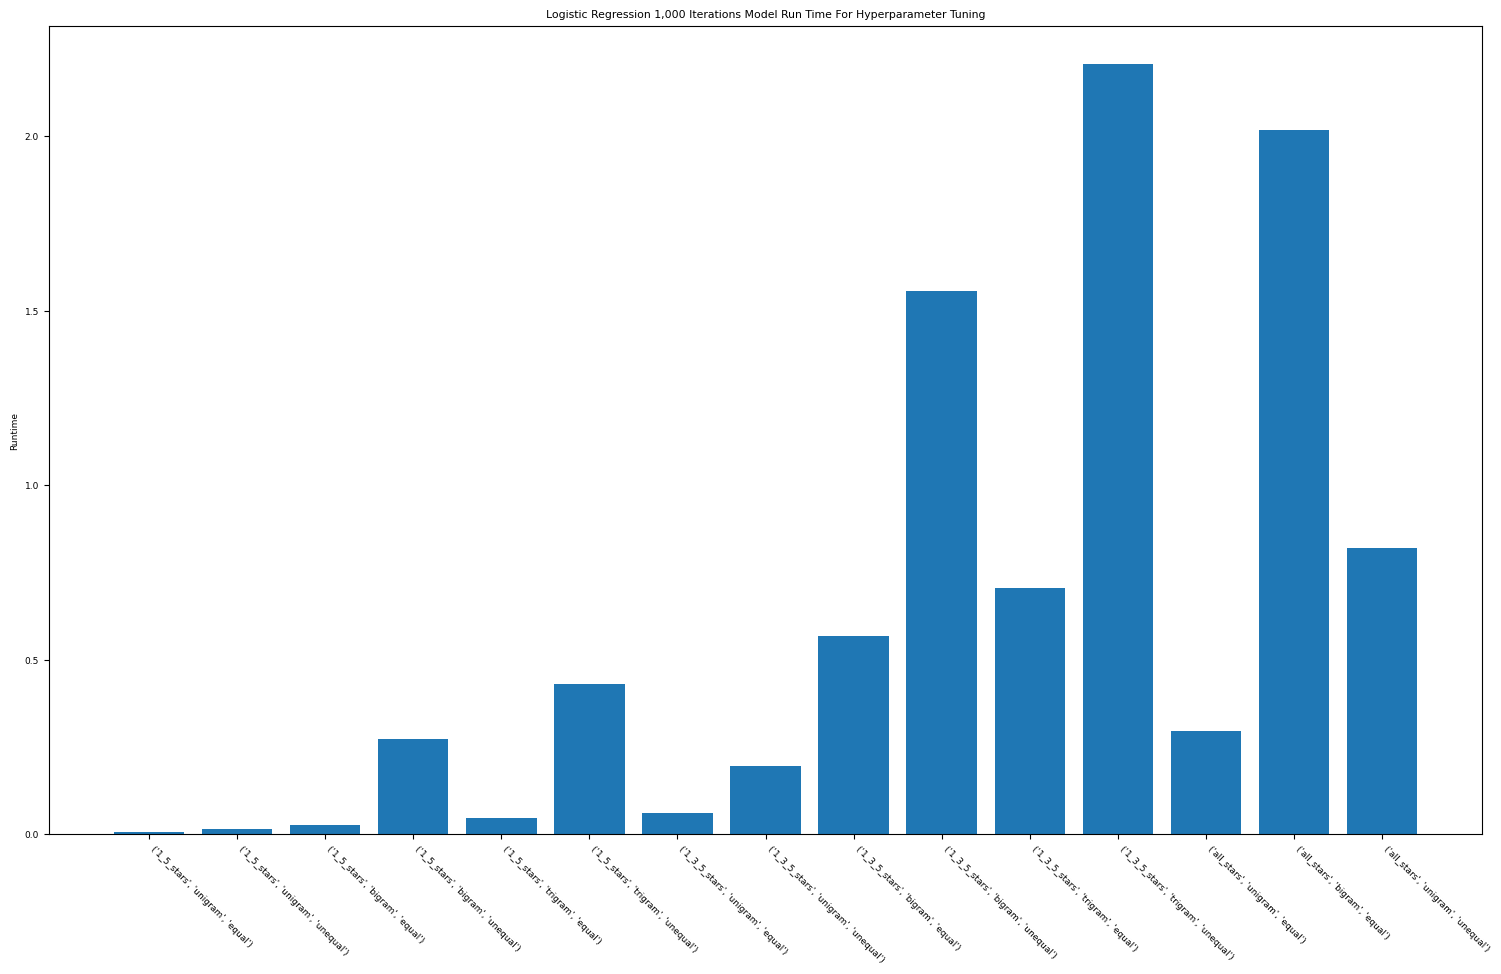

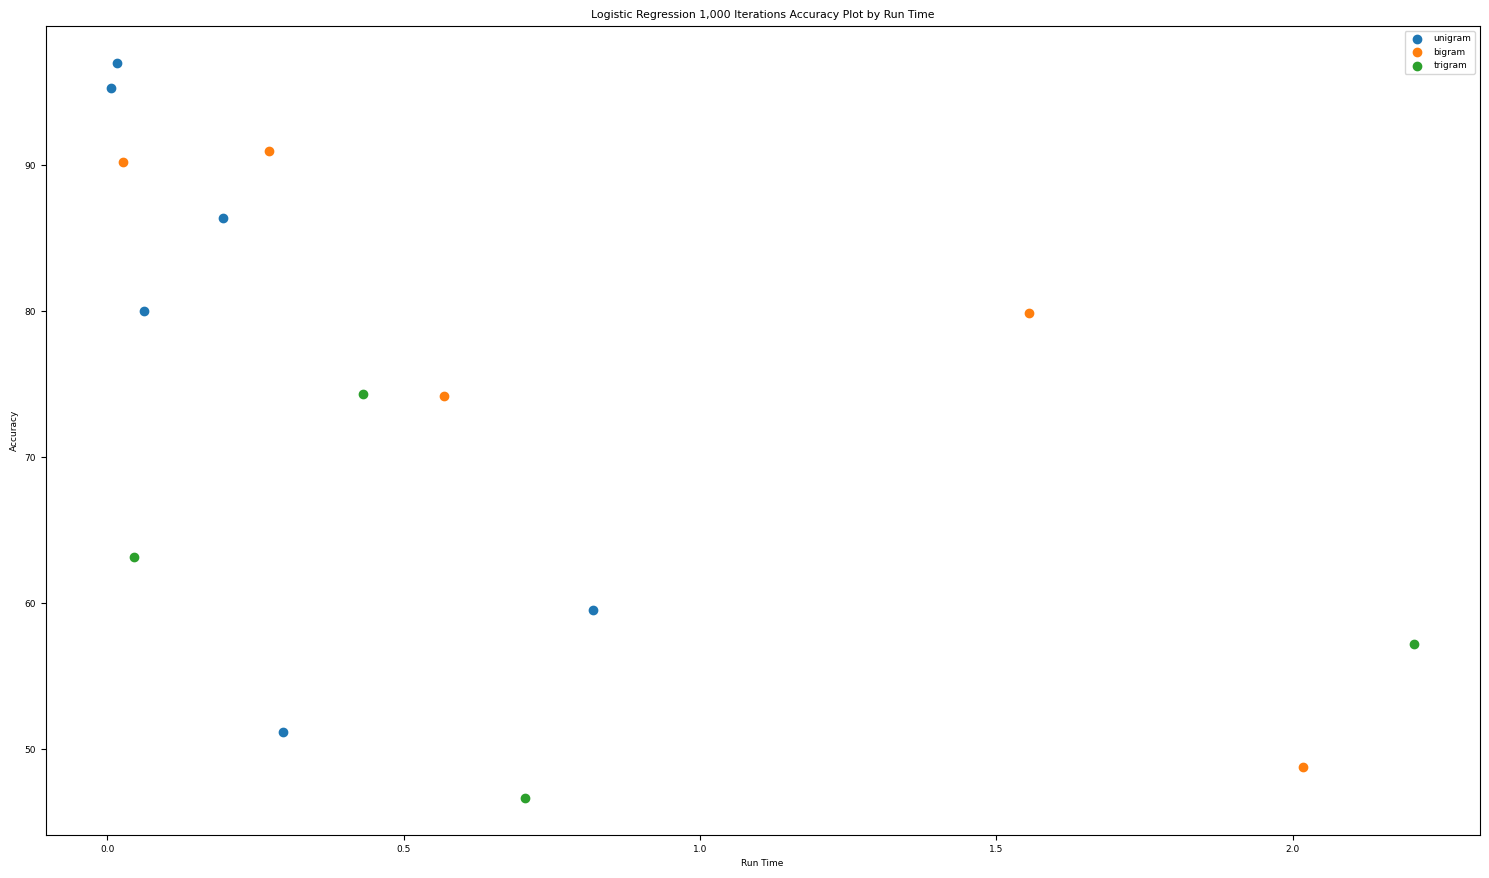

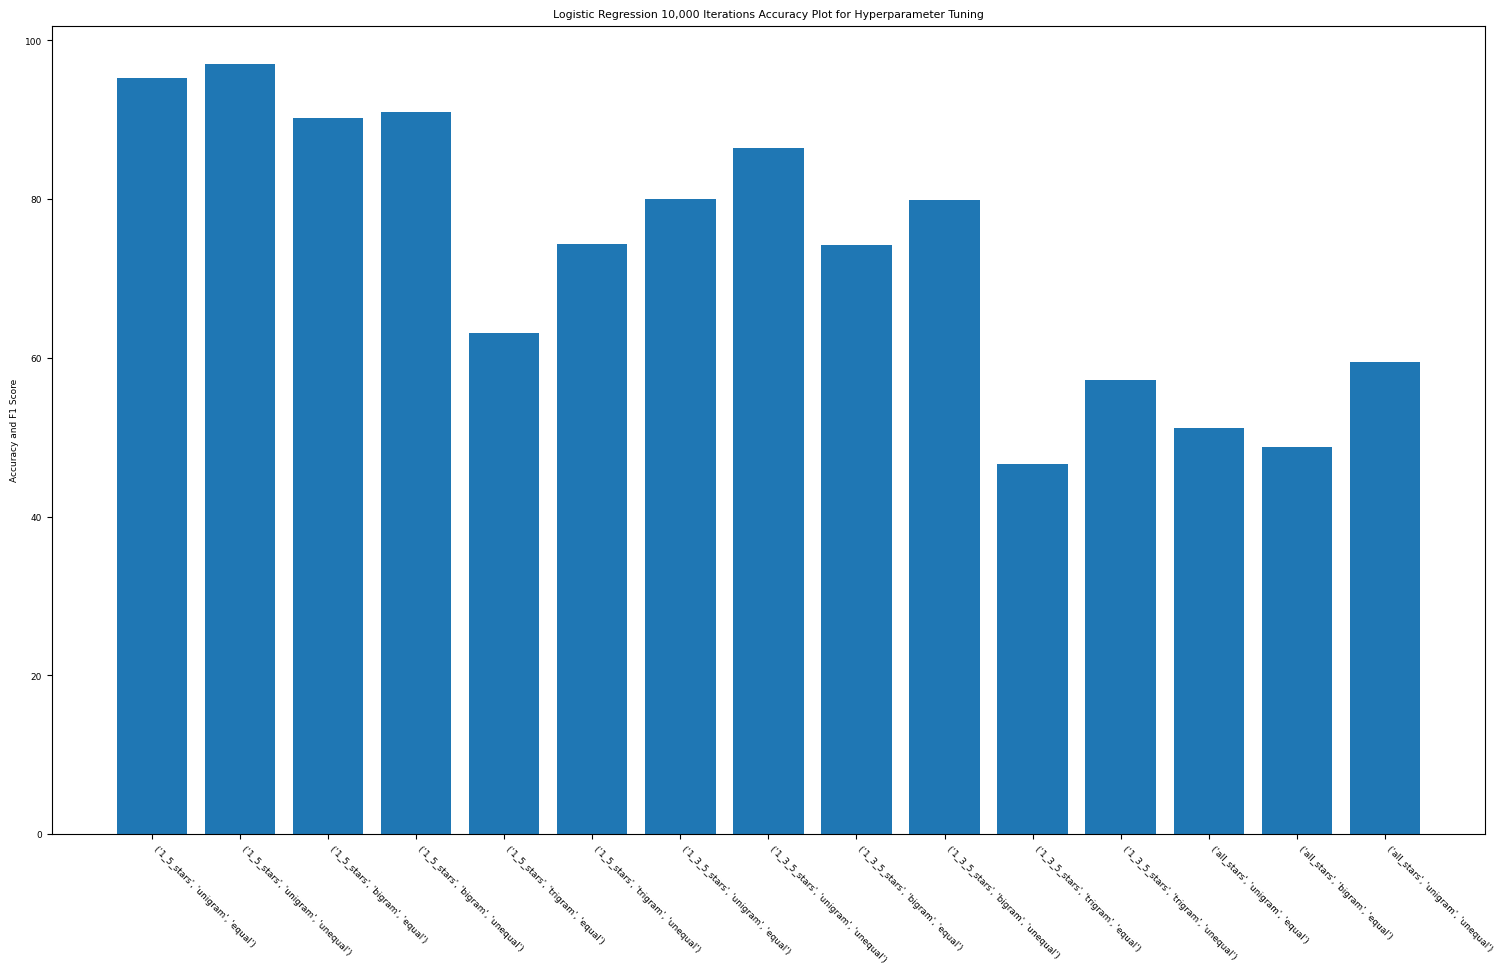

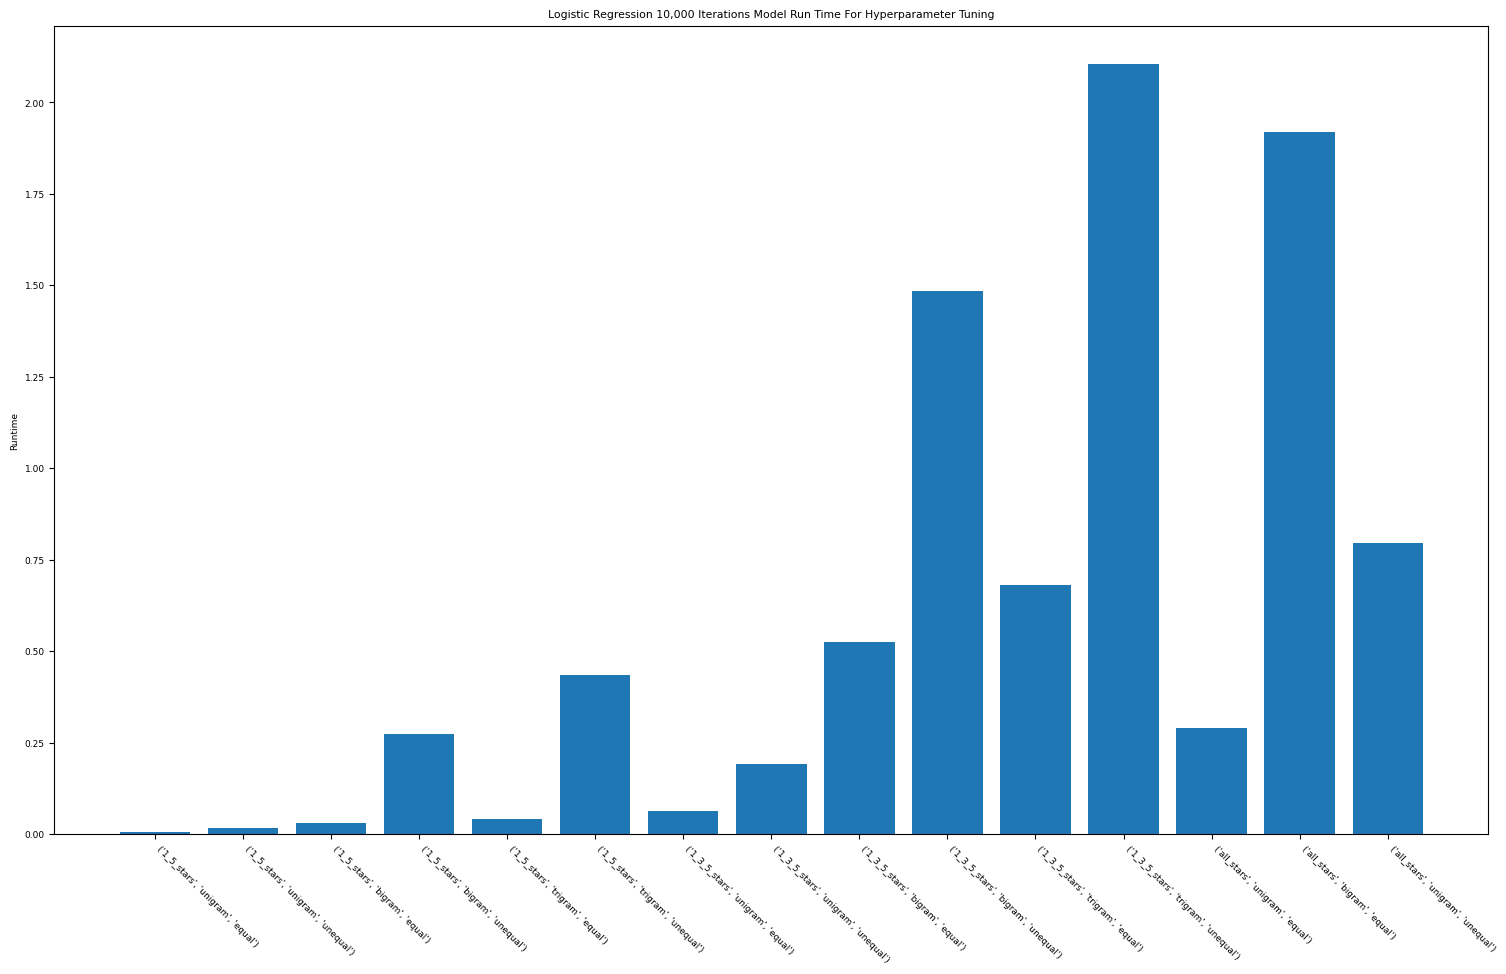

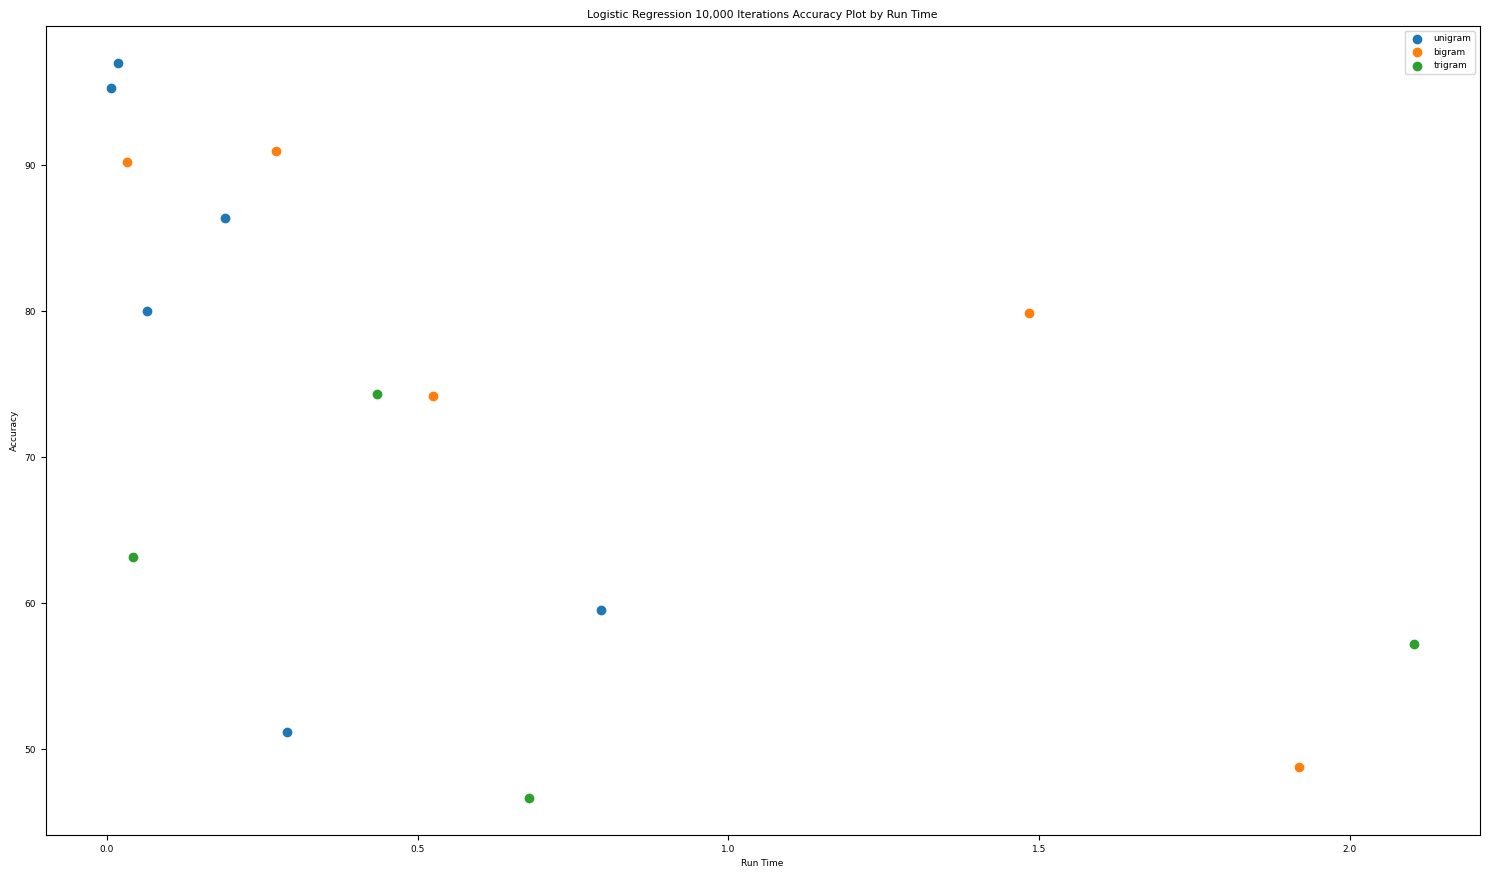

In [125]:
graph_score(new_combo, var_holder['lr_acc_100'], "Logistic Regression 100 Iterations")
graph_time(new_combo, var_holder['time_lst_100'], "Logistic Regression 100 Iterations")
scatter_graph(new_combo, var_holder['lr_acc_100'], var_holder['time_lst_100'], "Logistic Regression 100 Iterations")

graph_score(new_combo, var_holder['lr_acc_1000'], "Logistic Regression 1,000 Iterations")
graph_time(new_combo, var_holder['time_lst_1000'], "Logistic Regression 1,000 Iterations")
scatter_graph(new_combo, var_holder['lr_acc_1000'], var_holder['time_lst_1000'], "Logistic Regression 1,000 Iterations")

graph_score(new_combo, var_holder['lr_acc_10000'], "Logistic Regression 10,000 Iterations")
graph_time(new_combo, var_holder['time_lst_10000'], "Logistic Regression 10,000 Iterations")
scatter_graph(new_combo, var_holder['lr_acc_10000'], var_holder['time_lst_10000'], "Logistic Regression 10,000 Iterations")


### 10. Big O notation of each model's training time complexity.

| Multinomial Naive Bayes | Logistic Regression | Decision Tree Classifier | Random Forest Classifier |
|-------------------------|---------------------|--------------------------|--------------------------|
|        $O(nd)$          |       $O(nd)$       |       $O(n\log(n)d)$      |     $O(n\log(n)dk)$       |

### Note: Adjusting hyperparameters due to accuracy and time complexity:
#### From this point, we can see that the hyperparameter of n-grams decreases in accuracy as the size of the n-gram increases across all models. This may be due to how sparce each n-gram matrix becomes as the complexity grows. The uni, bi, and tri-grams all have the same number of rows. However, their columns differ based on the sparseness or number of unique values in each n-gram category. For example, unigrams have 67,824, bigrams have 1,976,754, and trigrams have 3,934,118 columns, which means the number of columns equals the number of unique n-grams. Therefore, since there are increasingly more unique n-grams when increasing the n-gram size, there are less repeated n-grams. This makes it harder for each model to classify each n-gram because of the sparseness. 

#### Furthermore, increasing the matrix and n-gram size adds signficantly to the run-time of each model. For example, modeling with the decision tree yields, on average, unigram models in less than 10 minutes, bigrams in less than 2 hours, and trigrams over 3 hours.

### 11. From the above models, we can compare the accuracy and F1 scores.

#### Multinomial Naive Bayes:
<table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 51.38 </span> | <span style='background:lightgreen'> 94.46 </span> | <span style='background:lightgoldenrodyellow'> 77.91 </span> |
| Bigram  | <span style='background:lightcoral'> 49.74 </span> | <span style='background:lightgreen'> 90.08 </span> | <span style='background:lightgoldenrodyellow'> 76.01 </span> |
| Trigram | <span style='background:lightcoral'> 29.68 </span> | <span style='background:lightcoral'> 56.57 </span> | <span style='background:lightcoral'> 42.48 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 58.44 </span> | <span style='background:lightgreen'> **94.57** </span> | <span style='background:lightgreen'> 84.24 </span> |
| Bigram  | <span style='background:lightcoral'> 54.61 </span> | <span style='background:lightgreen'> 91.53 </span> | <span style='background:lightgreen'> 81.84 </span> |
| Trigram | <span style='background:lightcoral'> 35.59 </span> | <span style='background:lightcoral'> 42.69 </span> | <span style='background:lightcoral'> 41.81 </span> |

</td></tr> </table>

#### Decision Tree Classifier:

 <table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 40.92 </span>| <span style='background:lightgreen'> 85.11 </span> | <span style='background:lightgoldenrodyellow'> 65.83 </span> |
| Bigram | <span style='background:lightcoral'> 37.16 </span> | <span style='background:lightgreen'> 80.26 </span> | <span style='background:lightgoldenrodyellow'> 62.15 </span> |
| Trigram | N/A | N/A | <span style='background:lightgoldenrodyellow'> 62.89 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 48.74 </span> | <span style='background:lightgreen'> **91.18** </span> | <span style='background:lightgoldenrodyellow'> 75.18 </span> |
| Bigram  | <span style='background:lightcoral'> 46.38 </span> | <span style='background:lightgreen'> 84.77 </span> | <span style='background:lightgoldenrodyellow'> 71.0 </span> |
| Trigram | N/A | N/A | <span style='background:lightcoral'> 46.61 </span> |

</td></tr> </table>

#### Random Forest Classifier:

 <table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 49.8 </span> | <span style='background:lightgreen'> **94.43** </span> | <span style='background:lightgoldenrodyellow'> 78.51 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 49.0 </span> | <span style='background:lightgreen'> 94.11 </span> | <span style='background:lightgoldenrodyellow'> 77.09 </span> |

</td></tr> </table>

#### Logistic Regression:
##### 100 Iterations:

 <table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 51.11 </span> | <span style='background:lightgreen'> 95.28 </span> | <span style='background:lightgreen'> 80.03 </span> |
| Bigram  | <span style='background:lightcoral'> 48.8 </span> | <span style='background:lightgreen'> 90.24 </span> | <span style='background:lightgoldenrodyellow'> 74.19 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 63.17 </span> | <span style='background:lightcoral'> 46.65 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 59.54 </span> | <span style='background:lightgreen'> **97.0** </span> | <span style='background:lightgreen'> 86.47 </span> |
| Bigram  | N/A | <span style='background:lightgreen'> 90.99 </span> | <span style='background:lightgoldenrodyellow'> 79.88 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 74.3 </span> | <span style='background:lightcoral'> 57.22 </span> |

</td></tr> </table>

##### 1,000 Iterations:

 <table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 51.19 </span> | <span style='background:lightgreen'> 95.28 </span> | <span style='background:lightgreen'> 80.03 </span> |
| Bigram  | <span style='background:lightcoral'> 48.8 </span> | <span style='background:lightgreen'> 90.24 </span> | <span style='background:lightgoldenrodyellow'> 74.19 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 63.17 </span> | <span style='background:lightcoral'> 46.65 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 59.5 </span> | <span style='background:lightgreen'> **97.0** </span> | <span style='background:lightgreen'> 86.4 </span> |
| Bigram  | N/A | <span style='background:lightgreen'>  90.99 </span> | <span style='background:lightgoldenrodyellow'> 79.86 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 74.3 </span> | <span style='background:lightcoral'> 57.22 </span> |

</td></tr> </table>

##### 10,000 Iterations:

 <table>
<tr><th>Equal </th><th>Unequal</th></tr>

<tr><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 51.19 </span> | <span style='background:lightgreen'> 95.28 </span> | <span style='background:lightgreen'> 80.03 </span> |
| Bigram  | <span style='background:lightcoral'> 48.8 </span> | <span style='background:lightgreen'> 90.24 </span> | <span style='background:lightgoldenrodyellow'> 74.19 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 63.17 </span> | <span style='background:lightcoral'> 46.65 </span> |

</td><td>

|         | 1-5 star | 1 & 5 star | 1, 3, 5 star |
|---------|----------|------------|--------------|
| Unigram | <span style='background:lightcoral'> 59.5 </span> | <span style='background:lightgreen'> **97.0** </span> | <span style='background:lightgreen'> 86.4 </span> |
| Bigram  | N/A | <span style='background:lightgreen'> 90.99 </span> | <span style='background:lightgoldenrodyellow'> 79.86 </span> |
| Trigram | N/A | <span style='background:lightgoldenrodyellow'> 74.3 </span> | <span style='background:lightcoral'> 57.22 </span> |

</td></tr> </table>

#### From this and the figures above, it is clear that trigrams performed worst in both accuracy and runtime, which can most likely be attributed from the number of unique trigram combinations and the relatively low frequency per combination. Additionally, including all star ratings in the model resulted in low accuracy and a somewhat poor runtime. These trends were present with all models. Ultimately, logistic regression with a dataset containing unigram, 1 & 5 star reviews yielded the strongest accuracy without dramatically sacrificing run-time.

### Note: Further Analysis with Logistic Regression.
#### You may find a deeper analysis with more extensive hyperparameter tuning in the notebook titled: Further Analysis with Logistic Regression located in the same Github repository folder as this notebook.

### 12. Classify a positive and negative review to test model performance.

In [114]:

yelp_train = yelp_sample_equal[(yelp_sample_equal['stars']==1) | (yelp_sample_equal['stars']==5)]

print()
print("Sample positive review:")
print(yelp_train['text'][5][1])

yelp_unigram_vocab = (CountVectorizer(ngram_range=(1,1), stop_words='english').fit(yelp_train.loc[:, 'text']))
pos_rev_trans = yelp_unigram_vocab.transform([yelp_train['text'][5][1]])

(x_train, x_test, y_train, y_test) = train_test_split(yelp_unigram_vocab.transform(yelp_train['text']), 
                                                     yelp_train['stars'], 
                                                     test_size=0.2, 
                                                     random_state=101)

log = LogisticRegression(C= 10, penalty='l1', solver='liblinear')
log.fit(x_train, y_train)

print()
print("Actual Rating: ", yelp_train['stars'][5][1])
print("Predicted Rating:", log.predict(pos_rev_trans)[0])

print()
print("Sample negative review:")
print(yelp_train['text'][1][5])

neg_rev_trans = yelp_unigram_vocab.transform([yelp_train['text'][1][5]])

print()
print("Actual Rating: ", yelp_train['stars'][1][5])
print("Predicted Rating:", log.predict(neg_rev_trans)[0])



Sample positive review:
I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.

For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).

There is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!

Actual Rating:  5.0
Predicted Rating: 5.0

Sample negative review:
I am a long term frequent customer of this establishment. I just went in to o